In [1]:
import os
import pandas as pd
path = r"C:\Users\Wong\Desktop\Dissertation\Imputed_dataset"
Albermarle_rainfall = pd.read_csv(os.path.join(path, 'Albermarle_rainfall.csv'))
Riding_Mill_water = pd.read_csv(os.path.join(path, 'Riding_Mill_water.csv'))

In [2]:
Albermarle_rainfall['dateTime'] = pd.to_datetime(Albermarle_rainfall['dateTime'])
Riding_Mill_water['dateTime'] = pd.to_datetime(Riding_Mill_water['dateTime'])

In [3]:
Riding_Mill_water.set_index('dateTime', inplace=True)
Albermarle_rainfall.set_index('dateTime', inplace=True)

In [8]:
start_date = pd.to_datetime('11/03/2020 00:00:00', format='%d/%m/%Y %H:%M:%S')
end_date = pd.to_datetime('05/09/2023 00:00:00', format='%d/%m/%Y %H:%M:%S')
Riding_Mill_water_subset = Riding_Mill_water.loc[(Riding_Mill_water.index >= start_date) & (Riding_Mill_water.index <= end_date)]
Albermarle_rainfall_subset = Albermarle_rainfall.loc[(Albermarle_rainfall.index >= start_date) & (Albermarle_rainfall.index <= end_date)]

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Dense, Dropout

In [9]:
Albermarle_rainfall_subset.shape

(122209, 1)

In [10]:
Riding_Mill_water_subset.shape

(122209, 1)

In [11]:
merged_data = pd.merge(Albermarle_rainfall_subset, Riding_Mill_water_subset, on='dateTime', how='inner')

In [12]:
train_merged, valid_merged, test_merged = merged_data[1:97767], merged_data[97767:109987],merged_data[109987:122209]

In [13]:
train_RidingMill = train_merged
scalers_RidingMill={}
for i in train_merged.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    transform = scaler.fit_transform(train_RidingMill[i].values.reshape(-1,1))
    transform=np.reshape(transform,len(transform))
    scalers_RidingMill['scaler_'+ i] = scaler
    train_RidingMill[i]=transform
test_RidingMill = test_merged
for i in test_merged.columns:
    scaler = scalers_RidingMill['scaler_'+i]
    transform = scaler.transform(test_RidingMill[i].values.reshape(-1,1))
    transform=np.reshape(transform,len(transform))
    scalers_RidingMill['scaler_'+i] = scaler
    test_RidingMill[i]=transform
valid_RidingMill = valid_merged
for i in valid_merged.columns:
    scaler = scalers_RidingMill['scaler_'+i]
    transform = scaler.transform(valid_RidingMill[i].values.reshape(-1,1))
    transform=np.reshape(transform,len(transform))
    scalers_RidingMill['scaler_'+i] = scaler
    valid_RidingMill[i]=transform

C:\Users\Wong\AppData\Local\Temp\ipykernel_55404\188171881.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_RidingMill[i]=transform
C:\Users\Wong\AppData\Local\Temp\ipykernel_55404\188171881.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_RidingMill[i]=transform
C:\Users\Wong\AppData\Local\Temp\ipykernel_55404\188171881.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

In [14]:
def split(series, n_past, n_future):
    X, y = list(), list()
    for start in range(len(series)):
        p_end = start + n_past
        f_end = p_end + n_future
        if f_end > len(series):
            break
        past_window, future_window = series[start:p_end, :], series[p_end:f_end, :]
        X.append(past_window)
        y.append(future_window)
    return np.array(X), np.array(y)

In [15]:
n_past = 96
n_future = 48 
n_features = 2
X_train, y_train = split(train_RidingMill.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split(test_RidingMill.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
X_valid, y_valid = split(valid_RidingMill.values,n_past, n_future)
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1],n_features))
y_valid = y_valid.reshape((y_valid.shape[0], y_valid.shape[1], n_features))

In [16]:
e_in = tf.keras.layers.Input(shape=(n_past, n_features))
e_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
e_outs1 = e_l1(e_in)
e_states1 = e_outs1[1:]
e_l2 = tf.keras.layers.LSTM(100, return_state=True)
e_outs2 = e_l2(e_outs1[0])
e_states2 = e_outs2[1:]

d_in = tf.keras.layers.RepeatVector(n_future)(e_outs2[0])

d_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(d_in,initial_state = e_states1)
d_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(d_l1,initial_state = e_states2)
d_outs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(d_l2)

model_e2d2_batch_32_96_in_RidingMill= tf.keras.models.Model(e_in,d_outs2)

In [17]:
reduce_learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e2d2_batch_32_96_in_RidingMill.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2_batch_32_96_in_RidingMill=model_e2d2_batch_32_96_in_RidingMill.fit(X_train,y_train,epochs=25,validation_data=(X_valid,y_valid),batch_size=32,verbose=1,callbacks=[reduce_learning_rate])

Epoch 1/25
3051/3051 [==============================] - 648s 210ms/step - loss: 0.0018 - val_loss: 9.2675e-04 - lr: 0.0010
Epoch 2/25
3051/3051 [==============================] - 588s 193ms/step - loss: 0.0012 - val_loss: 8.6638e-04 - lr: 9.0000e-04
Epoch 3/25
3051/3051 [==============================] - 565s 185ms/step - loss: 0.0010 - val_loss: 9.9181e-04 - lr: 8.1000e-04
Epoch 4/25
3051/3051 [==============================] - 569s 186ms/step - loss: 9.7453e-04 - val_loss: 8.4118e-04 - lr: 7.2900e-04
Epoch 5/25
3051/3051 [==============================] - 565s 185ms/step - loss: 9.1046e-04 - val_loss: 8.0182e-04 - lr: 6.5610e-04
Epoch 6/25
3051/3051 [==============================] - 563s 185ms/step - loss: 8.7447e-04 - val_loss: 7.3592e-04 - lr: 5.9049e-04
Epoch 7/25
3051/3051 [==============================] - 568s 186ms/step - loss: 8.3783e-04 - val_loss: 6.8231e-04 - lr: 5.3144e-04
Epoch 8/25
3051/3051 [==============================] - 566s 185ms/step - loss: 8.0751e-04 - val_lo

In [18]:
import pickle
with open('history_e2d2_batch_32_96_in_RidingMill.pkl', 'wb') as file:
    pickle.dump(history_e2d2_batch_32_96_in_RidingMill.history, file)

In [19]:
from keras.models import load_model
model_e2d2_batch_32_96_in_RidingMill.save('model_e2d2_batch_32_96_in_RidingMill.h5')

In [20]:
pred_e2d2_batch_32_96_in_RidingMill=model_e2d2_batch_32_96_in_RidingMill.predict(X_test)

378/378 [==============================] - 26s 65ms/step


In [21]:
for index,i in enumerate(train_merged.columns):
    scaler = scalers_RidingMill['scaler_'+i]
    pred_e2d2_batch_32_96_in_RidingMill[:,:,index]=scaler.inverse_transform(pred_e2d2_batch_32_96_in_RidingMill[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])
    y_valid[:,:,index]=scaler.inverse_transform(y_valid[:,:,index])

In [22]:
def calculate_nse(y_true, y_pred):
    
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

for index, i in enumerate(train_merged.columns):
    print(i)
    for j in range(1, 49):
        print("time ", j, ":")
        mae = mean_absolute_error(y_test[:, j - 1, index], pred_e2d2_batch_32_96_in_RidingMill[:, j - 1, index])
        mse = mean_squared_error(y_test[:, j - 1, index], pred_e2d2_batch_32_96_in_RidingMill[:, j - 1, index])
        nse = calculate_nse(y_test[:, j - 1, index], pred_e2d2_batch_32_96_in_RidingMill[:, j - 1, index])
        print("MAE: ", mae)
        print("MSE: ", mse)
        print("NSE: ", nse)
    print()

value_x
time  1 :
MAE:  0.0449267511899152
MSE:  0.026779569640832154
NSE:  0.14850650477938776
time  2 :
MAE:  0.04223029984771756
MSE:  0.03169519009184611
NSE:  -0.007792453536573207
time  3 :
MAE:  0.04033523595572919
MSE:  0.03089587031410554
NSE:  0.0176230255198756
time  4 :
MAE:  0.036550228077998785
MSE:  0.030208316476854964
NSE:  0.03948475174941801
time  5 :
MAE:  0.035081824909743604
MSE:  0.030213768844923047
NSE:  0.03931138615744678
time  6 :
MAE:  0.03468806010739812
MSE:  0.030373967538097537
NSE:  0.03421764689985485
time  7 :
MAE:  0.03441836210421867
MSE:  0.0305282909842387
NSE:  0.029310719256444684
time  8 :
MAE:  0.03389004206300147
MSE:  0.030625066984929047
NSE:  0.026233592320257793
time  9 :
MAE:  0.03342881186512371
MSE:  0.030775393207744726
NSE:  0.021453761926961912
time  10 :
MAE:  0.03316875381652897
MSE:  0.031093646514033912
NSE:  0.011334457405932752
time  11 :
MAE:  0.0329784775561909
MSE:  0.03136328549997822
NSE:  0.0027609125107453947
time  12 

In [23]:
n_past = 96
n_future = 48 
n_features = 2
X_train, y_train = split(train_RidingMill.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split(test_RidingMill.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
X_valid, y_valid = split(valid_RidingMill.values,n_past, n_future)
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1],n_features))
y_valid = y_valid.reshape((y_valid.shape[0], y_valid.shape[1], n_features))

In [24]:
e_in = tf.keras.layers.Input(shape=(n_past, n_features))
e_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
e_outs1 = e_l1(e_in)
e_states1 = e_outs1[1:]
e_l2 = tf.keras.layers.LSTM(100, return_state=True)
e_outs2 = e_l2(e_outs1[0])
e_states2 = e_outs2[1:]

d_in = tf.keras.layers.RepeatVector(n_future)(e_outs2[0])

d_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(d_in,initial_state = e_states1)
d_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(d_l1,initial_state = e_states2)
d_outs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(d_l2)

model_e2d2_batch_64_96_in_RidingMill= tf.keras.models.Model(e_in,d_outs2)

In [25]:
reduce_learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e2d2_batch_64_96_in_RidingMill.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2_batch_64_96_in_RidingMill=model_e2d2_batch_64_96_in_RidingMill.fit(X_train,y_train,epochs=25,validation_data=(X_valid,y_valid),batch_size=64,verbose=1,callbacks=[reduce_learning_rate])

Epoch 1/25
1526/1526 [==============================] - 513s 332ms/step - loss: 0.0023 - val_loss: 9.6451e-04 - lr: 0.0010
Epoch 2/25
1526/1526 [==============================] - 495s 325ms/step - loss: 0.0012 - val_loss: 0.0010 - lr: 9.0000e-04
Epoch 3/25
1526/1526 [==============================] - 489s 321ms/step - loss: 0.0011 - val_loss: 9.2329e-04 - lr: 8.1000e-04
Epoch 4/25
1526/1526 [==============================] - 494s 324ms/step - loss: 0.0010 - val_loss: 8.7575e-04 - lr: 7.2900e-04
Epoch 5/25
1526/1526 [==============================] - 492s 323ms/step - loss: 9.5258e-04 - val_loss: 7.3848e-04 - lr: 6.5610e-04
Epoch 6/25
1526/1526 [==============================] - 490s 321ms/step - loss: 8.9445e-04 - val_loss: 8.1790e-04 - lr: 5.9049e-04
Epoch 7/25
1526/1526 [==============================] - 493s 323ms/step - loss: 8.8684e-04 - val_loss: 7.8341e-04 - lr: 5.3144e-04
Epoch 8/25
1526/1526 [==============================] - 494s 324ms/step - loss: 8.5064e-04 - val_loss: 6.52

In [26]:
import pickle
with open('history_e2d2_batch_64_96_in_RidingMill.pkl', 'wb') as file:
    pickle.dump(history_e2d2_batch_64_96_in_RidingMill.history, file)

In [27]:
from keras.models import load_model
model_e2d2_batch_64_96_in_RidingMill.save('model_e2d2_batch_64_96_in_RidingMill.h5')

In [28]:
pred_e2d2_batch_64_96_in_RidingMill=model_e2d2_batch_64_96_in_RidingMill.predict(X_test)

378/378 [==============================] - 27s 67ms/step


In [29]:
for index,i in enumerate(train_merged.columns):
    scaler = scalers_RidingMill['scaler_'+i]
    pred_e2d2_batch_64_96_in_RidingMill[:,:,index]=scaler.inverse_transform(pred_e2d2_batch_64_96_in_RidingMill[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])
    y_valid[:,:,index]=scaler.inverse_transform(y_valid[:,:,index])

In [30]:
def calculate_nse(y_true, y_pred):
    
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

for index, i in enumerate(train_merged.columns):
    print(i)
    for j in range(1, 49):
        print("time ", j, ":")
        mae = mean_absolute_error(y_test[:, j - 1, index], pred_e2d2_batch_64_96_in_RidingMill[:, j - 1, index])
        mse = mean_squared_error(y_test[:, j - 1, index], pred_e2d2_batch_64_96_in_RidingMill[:, j - 1, index])
        nse = calculate_nse(y_test[:, j - 1, index], pred_e2d2_batch_64_96_in_RidingMill[:, j - 1, index])
        print("MAE: ", mae)
        print("MSE: ", mse)
        print("NSE: ", nse)
    print()

value_x
time  1 :
MAE:  0.04259325908069056
MSE:  0.02844983834427432
NSE:  0.09539799873069332
time  2 :
MAE:  0.0385893547038525
MSE:  0.029368976242056467
NSE:  0.06617273664959866
time  3 :
MAE:  0.035637752357841036
MSE:  0.029806881153007482
NSE:  0.052248943690976324
time  4 :
MAE:  0.03592933355868776
MSE:  0.029681194813128392
NSE:  0.05624531489038331
time  5 :
MAE:  0.036847445970537324
MSE:  0.029601256921598824
NSE:  0.058787050832072696
time  6 :
MAE:  0.037402383771318895
MSE:  0.029654864398705343
NSE:  0.05708252687356263
time  7 :
MAE:  0.03729403668735307
MSE:  0.029896393323105355
NSE:  0.049402780305841
time  8 :
MAE:  0.03675791658069412
MSE:  0.030252188751087847
NSE:  0.03808977204545472
time  9 :
MAE:  0.03601813579851136
MSE:  0.03062011518894466
NSE:  0.026391041529745363
time  10 :
MAE:  0.03530459249441035
MSE:  0.03095785943384628
NSE:  0.01565199562874542
time  11 :
MAE:  0.03471622158137069
MSE:  0.03115581434630824
NSE:  0.009357745102354431
time  12 :


In [31]:
n_past = 96
n_future = 48 
n_features = 2
X_train, y_train = split(train_RidingMill.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split(test_RidingMill.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
X_valid, y_valid = split(valid_RidingMill.values,n_past, n_future)
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1],n_features))
y_valid = y_valid.reshape((y_valid.shape[0], y_valid.shape[1], n_features))

In [32]:
e_in = tf.keras.layers.Input(shape=(n_past, n_features))
e_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
e_outs1 = e_l1(e_in)
e_states1 = e_outs1[1:]
e_l2 = tf.keras.layers.LSTM(100, return_state=True)
e_outs2 = e_l2(e_outs1[0])
e_states2 = e_outs2[1:]

d_in = tf.keras.layers.RepeatVector(n_future)(e_outs2[0])

d_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(d_in,initial_state = e_states1)
d_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(d_l1,initial_state = e_states2)
d_outs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(d_l2)

model_e2d2_batch_128_96_in_RidingMill= tf.keras.models.Model(e_in,d_outs2)

In [33]:
reduce_learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e2d2_batch_128_96_in_RidingMill.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2_batch_128_96_in_RidingMill=model_e2d2_batch_128_96_in_RidingMill.fit(X_train,y_train,epochs=25,validation_data=(X_valid,y_valid),batch_size=128,verbose=1,callbacks=[reduce_learning_rate])

Epoch 1/25
763/763 [==============================] - 401s 518ms/step - loss: 0.0031 - val_loss: 0.0011 - lr: 0.0010
Epoch 2/25
763/763 [==============================] - 391s 513ms/step - loss: 0.0013 - val_loss: 0.0010 - lr: 9.0000e-04
Epoch 3/25
763/763 [==============================] - 390s 511ms/step - loss: 0.0012 - val_loss: 9.7523e-04 - lr: 8.1000e-04
Epoch 4/25
763/763 [==============================] - 390s 511ms/step - loss: 0.0011 - val_loss: 8.4623e-04 - lr: 7.2900e-04
Epoch 5/25
763/763 [==============================] - 390s 511ms/step - loss: 0.0011 - val_loss: 9.8612e-04 - lr: 6.5610e-04
Epoch 6/25
763/763 [==============================] - 395s 518ms/step - loss: 0.0010 - val_loss: 7.5181e-04 - lr: 5.9049e-04
Epoch 7/25
763/763 [==============================] - 391s 512ms/step - loss: 9.7237e-04 - val_loss: 8.0890e-04 - lr: 5.3144e-04
Epoch 8/25
763/763 [==============================] - 393s 516ms/step - loss: 9.3213e-04 - val_loss: 8.0414e-04 - lr: 4.7830e-04
Epoc

In [34]:
import pickle
with open('history_e2d2_batch_128_96_in_RidingMill.pkl', 'wb') as file:
    pickle.dump(history_e2d2_batch_128_96_in_RidingMill.history, file)

In [35]:
from keras.models import load_model
model_e2d2_batch_128_96_in_RidingMill.save('model_e2d2_batch_128_96_in_RidingMill.h5')

In [36]:
pred_e2d2_batch_128_96_in_RidingMill=model_e2d2_batch_128_96_in_RidingMill.predict(X_test)

378/378 [==============================] - 28s 70ms/step


In [37]:
for index,i in enumerate(train_merged.columns):
    scaler = scalers_RidingMill['scaler_'+i]
    pred_e2d2_batch_128_96_in_RidingMill[:,:,index]=scaler.inverse_transform(pred_e2d2_batch_128_96_in_RidingMill[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])
    y_valid[:,:,index]=scaler.inverse_transform(y_valid[:,:,index])

In [38]:
def calculate_nse(y_true, y_pred):
    
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

for index, i in enumerate(train_merged.columns):
    print(i)
    for j in range(1, 49):
        print("time ", j, ":")
        mae = mean_absolute_error(y_test[:, j - 1, index], pred_e2d2_batch_128_96_in_RidingMill[:, j - 1, index])
        mse = mean_squared_error(y_test[:, j - 1, index], pred_e2d2_batch_128_96_in_RidingMill[:, j - 1, index])
        nse = calculate_nse(y_test[:, j - 1, index], pred_e2d2_batch_128_96_in_RidingMill[:, j - 1, index])
        print("MAE: ", mae)
        print("MSE: ", mse)
        print("NSE: ", nse)
    print()

value_x
time  1 :
MAE:  0.046194666777534275
MSE:  0.027911732819117952
NSE:  0.11250780895386758
time  2 :
MAE:  0.0435500315122133
MSE:  0.028895729032535324
NSE:  0.0812202869255424
time  3 :
MAE:  0.041881377873253724
MSE:  0.029281042025501625
NSE:  0.06896872681702826
time  4 :
MAE:  0.04015076757316232
MSE:  0.029435615187754567
NSE:  0.06405385910409189
time  5 :
MAE:  0.03980035384331567
MSE:  0.02957870285763576
NSE:  0.05950418852371264
time  6 :
MAE:  0.039832911634299126
MSE:  0.02978072817566856
NSE:  0.053080513816389896
time  7 :
MAE:  0.039835571449258304
MSE:  0.030089802264048136
NSE:  0.04325307523816957
time  8 :
MAE:  0.0397269889607474
MSE:  0.030463534787373837
NSE:  0.031369732195979716
time  9 :
MAE:  0.03956146745731503
MSE:  0.030842786752283212
NSE:  0.0193108908665216
time  10 :
MAE:  0.0394404825069561
MSE:  0.03117959354870428
NSE:  0.008601652437934648
time  11 :
MAE:  0.03939077914160839
MSE:  0.03135679525400552
NSE:  0.002967278867720635
time  12 :
M

Now try different batch size for 48input

In [39]:
n_past = 48
n_future = 48 
n_features = 2
X_train, y_train = split(train_RidingMill.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split(test_RidingMill.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
X_valid, y_valid = split(valid_RidingMill.values,n_past, n_future)
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1],n_features))
y_valid = y_valid.reshape((y_valid.shape[0], y_valid.shape[1], n_features))

In [40]:
e_in = tf.keras.layers.Input(shape=(n_past, n_features))
e_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
e_outs1 = e_l1(e_in)
e_states1 = e_outs1[1:]
e_l2 = tf.keras.layers.LSTM(100, return_state=True)
e_outs2 = e_l2(e_outs1[0])
e_states2 = e_outs2[1:]

d_in = tf.keras.layers.RepeatVector(n_future)(e_outs2[0])

d_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(d_in,initial_state = e_states1)
d_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(d_l1,initial_state = e_states2)
d_outs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(d_l2)

model_e2d2_batch_32_48_in_RidingMill= tf.keras.models.Model(e_in,d_outs2)

In [41]:
reduce_learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e2d2_batch_32_48_in_RidingMill.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2_batch_32_48_in_RidingMill=model_e2d2_batch_32_48_in_RidingMill.fit(X_train,y_train,epochs=25,validation_data=(X_valid,y_valid),batch_size=32,verbose=1,callbacks=[reduce_learning_rate])

Epoch 1/25
3053/3053 [==============================] - 460s 148ms/step - loss: 0.0018 - val_loss: 9.6029e-04 - lr: 0.0010
Epoch 2/25
3053/3053 [==============================] - 443s 145ms/step - loss: 0.0011 - val_loss: 8.7324e-04 - lr: 9.0000e-04
Epoch 3/25
3053/3053 [==============================] - 447s 146ms/step - loss: 0.0010 - val_loss: 7.8343e-04 - lr: 8.1000e-04
Epoch 4/25
3053/3053 [==============================] - 483s 158ms/step - loss: 9.6326e-04 - val_loss: 7.3902e-04 - lr: 7.2900e-04
Epoch 5/25
3053/3053 [==============================] - 463s 152ms/step - loss: 9.1438e-04 - val_loss: 7.4265e-04 - lr: 6.5610e-04
Epoch 6/25
3053/3053 [==============================] - 463s 152ms/step - loss: 8.8187e-04 - val_loss: 7.3798e-04 - lr: 5.9049e-04
Epoch 7/25
3053/3053 [==============================] - 456s 149ms/step - loss: 8.5971e-04 - val_loss: 7.3997e-04 - lr: 5.3144e-04
Epoch 8/25
3053/3053 [==============================] - 461s 151ms/step - loss: 8.3197e-04 - val_lo

In [42]:
import pickle
with open('history_e2d2_batch_32_48_in_RidingMill.pkl', 'wb') as file:
    pickle.dump(history_e2d2_batch_32_48_in_RidingMill.history, file)

In [43]:
from keras.models import load_model
model_e2d2_batch_32_48_in_RidingMill.save('model_e2d2_batch_32_48_in_RidingMill.h5')

In [44]:
pred_e2d2_batch_32_48_in_RidingMill=model_e2d2_batch_32_48_in_RidingMill.predict(X_test)

379/379 [==============================] - 34s 79ms/step


In [45]:
for index,i in enumerate(train_merged.columns):
    scaler = scalers_RidingMill['scaler_'+i]
    pred_e2d2_batch_32_48_in_RidingMill[:,:,index]=scaler.inverse_transform(pred_e2d2_batch_32_48_in_RidingMill[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])
    y_valid[:,:,index]=scaler.inverse_transform(y_valid[:,:,index])

In [46]:
def calculate_nse(y_true, y_pred):
    
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

for index, i in enumerate(train_merged.columns):
    print(i)
    for j in range(1, 49):
        print("time ", j, ":")
        mae = mean_absolute_error(y_test[:, j - 1, index], pred_e2d2_batch_32_48_in_RidingMill[:, j - 1, index])
        mse = mean_squared_error(y_test[:, j - 1, index], pred_e2d2_batch_32_48_in_RidingMill[:, j - 1, index])
        nse = calculate_nse(y_test[:, j - 1, index], pred_e2d2_batch_32_48_in_RidingMill[:, j - 1, index])
        print("MAE: ", mae)
        print("MSE: ", mse)
        print("NSE: ", nse)
    print()

value_x
time  1 :
MAE:  0.04798121883871726
MSE:  0.028172068187460646
NSE:  0.10088536570053108
time  2 :
MAE:  0.038882143511032544
MSE:  0.029794553080905395
NSE:  0.04910358305259288
time  3 :
MAE:  0.03620453834573011
MSE:  0.030062407296802127
NSE:  0.04055498648634004
time  4 :
MAE:  0.03972405640243589
MSE:  0.029794175669885518
NSE:  0.04911562816652826
time  5 :
MAE:  0.03880562121313521
MSE:  0.029538874102989575
NSE:  0.057263605568410925
time  6 :
MAE:  0.0382610388833102
MSE:  0.029442249783091512
NSE:  0.060347381295187574
time  7 :
MAE:  0.037980020528890684
MSE:  0.029624290814441893
NSE:  0.05453752188973049
time  8 :
MAE:  0.03806885804388424
MSE:  0.029925818982514413
NSE:  0.0449142174605518
time  9 :
MAE:  0.0379604489449235
MSE:  0.030248179881379306
NSE:  0.0346260341519381
time  10 :
MAE:  0.037855874785313735
MSE:  0.030675995373573715
NSE:  0.020972255975182597
time  11 :
MAE:  0.03769972924595567
MSE:  0.030934064196593912
NSE:  0.01273596129174226
time  12 

In [48]:
n_past = 48
n_future = 48 
n_features = 2
X_train, y_train = split(train_RidingMill.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split(test_RidingMill.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
X_valid, y_valid = split(valid_RidingMill.values,n_past, n_future)
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1],n_features))
y_valid = y_valid.reshape((y_valid.shape[0], y_valid.shape[1], n_features))

In [49]:
e_in = tf.keras.layers.Input(shape=(n_past, n_features))
e_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
e_outs1 = e_l1(e_in)
e_states1 = e_outs1[1:]
e_l2 = tf.keras.layers.LSTM(100, return_state=True)
e_outs2 = e_l2(e_outs1[0])
e_states2 = e_outs2[1:]

d_in = tf.keras.layers.RepeatVector(n_future)(e_outs2[0])

d_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(d_in,initial_state = e_states1)
d_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(d_l1,initial_state = e_states2)
d_outs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(d_l2)

model_e2d2_batch_64_48_in_RidingMill= tf.keras.models.Model(e_in,d_outs2)

In [50]:
reduce_learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e2d2_batch_64_48_in_RidingMill.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2_batch_64_48_in_RidingMill=model_e2d2_batch_64_48_in_RidingMill.fit(X_train,y_train,epochs=25,validation_data=(X_valid,y_valid),batch_size=64,verbose=1,callbacks=[reduce_learning_rate])

Epoch 1/25
1527/1527 [==============================] - 390s 250ms/step - loss: 0.0022 - val_loss: 0.0011 - lr: 0.0010
Epoch 2/25
1527/1527 [==============================] - 374s 245ms/step - loss: 0.0012 - val_loss: 0.0014 - lr: 9.0000e-04
Epoch 3/25
1527/1527 [==============================] - 347s 227ms/step - loss: 0.0011 - val_loss: 8.3254e-04 - lr: 8.1000e-04
Epoch 4/25
1527/1527 [==============================] - 344s 225ms/step - loss: 0.0010 - val_loss: 7.9363e-04 - lr: 7.2900e-04
Epoch 5/25
1527/1527 [==============================] - 345s 226ms/step - loss: 9.6729e-04 - val_loss: 7.8411e-04 - lr: 6.5610e-04
Epoch 6/25
1527/1527 [==============================] - 345s 226ms/step - loss: 9.1872e-04 - val_loss: 7.1951e-04 - lr: 5.9049e-04
Epoch 7/25
1527/1527 [==============================] - 345s 226ms/step - loss: 8.8773e-04 - val_loss: 8.5969e-04 - lr: 5.3144e-04
Epoch 8/25
1527/1527 [==============================] - 346s 227ms/step - loss: 8.6834e-04 - val_loss: 7.1205e-

In [51]:
import pickle
with open('history_e2d2_batch_64_48_in_RidingMill.pkl', 'wb') as file:
    pickle.dump(history_e2d2_batch_64_48_in_RidingMill.history, file)

In [52]:
from keras.models import load_model
model_e2d2_batch_64_48_in_RidingMill.save('model_e2d2_batch_64_48_in_RidingMill.h5')

In [53]:
pred_e2d2_batch_64_48_in_RidingMill=model_e2d2_batch_64_48_in_RidingMill.predict(X_test)

379/379 [==============================] - 26s 60ms/step


In [54]:
for index,i in enumerate(train_merged.columns):
    scaler = scalers_RidingMill['scaler_'+i]
    pred_e2d2_batch_64_48_in_RidingMill[:,:,index]=scaler.inverse_transform(pred_e2d2_batch_64_48_in_RidingMill[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])
    y_valid[:,:,index]=scaler.inverse_transform(y_valid[:,:,index])

In [55]:
def calculate_nse(y_true, y_pred):
    
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

for index, i in enumerate(train_merged.columns):
    print(i)
    for j in range(1, 49):
        print("time ", j, ":")
        mae = mean_absolute_error(y_test[:, j - 1, index], pred_e2d2_batch_64_48_in_RidingMill[:, j - 1, index])
        mse = mean_squared_error(y_test[:, j - 1, index], pred_e2d2_batch_64_48_in_RidingMill[:, j - 1, index])
        nse = calculate_nse(y_test[:, j - 1, index], pred_e2d2_batch_64_48_in_RidingMill[:, j - 1, index])
        print("MAE: ", mae)
        print("MSE: ", mse)
        print("NSE: ", nse)
    print()

value_x
time  1 :
MAE:  0.039221845072650884
MSE:  0.027841498458057282
NSE:  0.11143553473268164
time  2 :
MAE:  0.038862414632142794
MSE:  0.029619166050824725
NSE:  0.05470107928050694
time  3 :
MAE:  0.036140225593615335
MSE:  0.029761094632533902
NSE:  0.0501714130880585
time  4 :
MAE:  0.03605648009157971
MSE:  0.029441608610788737
NSE:  0.06036784437928522
time  5 :
MAE:  0.03689515345898918
MSE:  0.029236928544068418
NSE:  0.06690023107212817
time  6 :
MAE:  0.037818134785524204
MSE:  0.029215925252288288
NSE:  0.06757055342412321
time  7 :
MAE:  0.03854670306172956
MSE:  0.02939148418232191
NSE:  0.06196757099042871
time  8 :
MAE:  0.03910315298843415
MSE:  0.029705455635635553
NSE:  0.05194713775321891
time  9 :
MAE:  0.03945620073335939
MSE:  0.030094328828322078
NSE:  0.03953620732011576
time  10 :
MAE:  0.03972558111352953
MSE:  0.03052927587709981
NSE:  0.02565482473580527
time  11 :
MAE:  0.0399090510853009
MSE:  0.03078358291197797
NSE:  0.017538587931933303
time  12 :


In [56]:
n_past = 48
n_future = 48 
n_features = 2
X_train, y_train = split(train_RidingMill.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split(test_RidingMill.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
X_valid, y_valid = split(valid_RidingMill.values,n_past, n_future)
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1],n_features))
y_valid = y_valid.reshape((y_valid.shape[0], y_valid.shape[1], n_features))

In [57]:
e_in = tf.keras.layers.Input(shape=(n_past, n_features))
e_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
e_outs1 = e_l1(e_in)
e_states1 = e_outs1[1:]
e_l2 = tf.keras.layers.LSTM(100, return_state=True)
e_outs2 = e_l2(e_outs1[0])
e_states2 = e_outs2[1:]

d_in = tf.keras.layers.RepeatVector(n_future)(e_outs2[0])

d_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(d_in,initial_state = e_states1)
d_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(d_l1,initial_state = e_states2)
d_outs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(d_l2)

model_e2d2_batch_128_48_in_RidingMill= tf.keras.models.Model(e_in,d_outs2)

In [58]:
reduce_learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e2d2_batch_128_48_in_RidingMill.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2_batch_128_48_in_RidingMill=model_e2d2_batch_128_48_in_RidingMill.fit(X_train,y_train,epochs=25,validation_data=(X_valid,y_valid),batch_size=128,verbose=1,callbacks=[reduce_learning_rate])

Epoch 1/25
764/764 [==============================] - 277s 355ms/step - loss: 0.0031 - val_loss: 0.0012 - lr: 0.0010
Epoch 2/25
764/764 [==============================] - 271s 355ms/step - loss: 0.0013 - val_loss: 9.8981e-04 - lr: 9.0000e-04
Epoch 3/25
764/764 [==============================] - 273s 357ms/step - loss: 0.0012 - val_loss: 9.4487e-04 - lr: 8.1000e-04
Epoch 4/25
764/764 [==============================] - 299s 391ms/step - loss: 0.0011 - val_loss: 0.0010 - lr: 7.2900e-04
Epoch 5/25
764/764 [==============================] - 272s 356ms/step - loss: 0.0010 - val_loss: 9.7915e-04 - lr: 6.5610e-04
Epoch 6/25
764/764 [==============================] - 272s 356ms/step - loss: 9.7104e-04 - val_loss: 7.7351e-04 - lr: 5.9049e-04
Epoch 7/25
764/764 [==============================] - 272s 356ms/step - loss: 9.4110e-04 - val_loss: 8.2195e-04 - lr: 5.3144e-04
Epoch 8/25
764/764 [==============================] - 271s 355ms/step - loss: 9.0978e-04 - val_loss: 7.9924e-04 - lr: 4.7830e-04


In [59]:
import pickle
with open('history_e2d2_batch_128_48_in_RidingMill.pkl', 'wb') as file:
    pickle.dump(history_e2d2_batch_128_48_in_RidingMill.history, file)

In [60]:
from keras.models import load_model
model_e2d2_batch_128_48_in_RidingMill.save('model_e2d2_batch_128_48_in_RidingMill.h5')

In [61]:
pred_e2d2_batch_128_48_in_RidingMill=model_e2d2_batch_128_48_in_RidingMill.predict(X_test)

379/379 [==============================] - 22s 54ms/step


In [62]:
for index,i in enumerate(train_merged.columns):
    scaler = scalers_RidingMill['scaler_'+i]
    pred_e2d2_batch_128_48_in_RidingMill[:,:,index]=scaler.inverse_transform(pred_e2d2_batch_128_48_in_RidingMill[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])
    y_valid[:,:,index]=scaler.inverse_transform(y_valid[:,:,index])

In [63]:
def calculate_nse(y_true, y_pred):
    
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

for index, i in enumerate(train_merged.columns):
    print(i)
    for j in range(1, 49):
        print("time ", j, ":")
        mae = mean_absolute_error(y_test[:, j - 1, index], pred_e2d2_batch_128_48_in_RidingMill[:, j - 1, index])
        mse = mean_squared_error(y_test[:, j - 1, index], pred_e2d2_batch_128_48_in_RidingMill[:, j - 1, index])
        nse = calculate_nse(y_test[:, j - 1, index], pred_e2d2_batch_128_48_in_RidingMill[:, j - 1, index])
        print("MAE: ", mae)
        print("MSE: ", mse)
        print("NSE: ", nse)
    print()

value_x
time  1 :
MAE:  0.045298179522816555
MSE:  0.028813514666281476
NSE:  0.08041353124414652
time  2 :
MAE:  0.03811316660823399
MSE:  0.02968418981420939
NSE:  0.052625838767551
time  3 :
MAE:  0.03690919936651879
MSE:  0.029728777503540065
NSE:  0.0512028177908852
time  4 :
MAE:  0.0367827266442409
MSE:  0.029611358378353648
NSE:  0.054950262000492134
time  5 :
MAE:  0.03632876148146809
MSE:  0.02949925148034269
NSE:  0.05852816589937715
time  6 :
MAE:  0.035959276097658546
MSE:  0.029501880143418157
NSE:  0.05844427183011469
time  7 :
MAE:  0.03581934245153518
MSE:  0.02970429573963167
NSE:  0.05198415596091388
time  8 :
MAE:  0.035726562259595744
MSE:  0.030054161720138802
NSE:  0.04081814496646674
time  9 :
MAE:  0.03553787980732761
MSE:  0.03046384888698374
NSE:  0.027742934273950803
time  10 :
MAE:  0.03533099680669606
MSE:  0.030870002061480807
NSE:  0.014780511333343571
time  11 :
MAE:  0.03513440192458438
MSE:  0.031116197814034654
NSE:  0.006923146991095308
time  12 :
M

now try different batch size for 24 input

In [64]:
n_past = 24
n_future = 48 
n_features = 2
X_train, y_train = split(train_RidingMill.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split(test_RidingMill.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
X_valid, y_valid = split(valid_RidingMill.values,n_past, n_future)
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1],n_features))
y_valid = y_valid.reshape((y_valid.shape[0], y_valid.shape[1], n_features))

In [65]:
e_in = tf.keras.layers.Input(shape=(n_past, n_features))
e_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
e_outs1 = e_l1(e_in)
e_states1 = e_outs1[1:]
e_l2 = tf.keras.layers.LSTM(100, return_state=True)
e_outs2 = e_l2(e_outs1[0])
e_states2 = e_outs2[1:]

d_in = tf.keras.layers.RepeatVector(n_future)(e_outs2[0])

d_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(d_in,initial_state = e_states1)
d_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(d_l1,initial_state = e_states2)
d_outs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(d_l2)

model_e2d2_batch_32_24_in_RidingMill= tf.keras.models.Model(e_in,d_outs2)

In [66]:
reduce_learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e2d2_batch_32_24_in_RidingMill.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2_batch_32_24_in_RidingMill=model_e2d2_batch_32_24_in_RidingMill.fit(X_train,y_train,epochs=25,validation_data=(X_valid,y_valid),batch_size=32,verbose=1,callbacks=[reduce_learning_rate])

Epoch 1/25
3053/3053 [==============================] - 399s 129ms/step - loss: 0.0018 - val_loss: 9.1550e-04 - lr: 0.0010
Epoch 2/25
3053/3053 [==============================] - 381s 125ms/step - loss: 0.0012 - val_loss: 9.2969e-04 - lr: 9.0000e-04
Epoch 3/25
3053/3053 [==============================] - 378s 124ms/step - loss: 0.0010 - val_loss: 7.9528e-04 - lr: 8.1000e-04
Epoch 4/25
3053/3053 [==============================] - 378s 124ms/step - loss: 9.7904e-04 - val_loss: 8.1662e-04 - lr: 7.2900e-04
Epoch 5/25
3053/3053 [==============================] - 379s 124ms/step - loss: 9.3771e-04 - val_loss: 7.7645e-04 - lr: 6.5610e-04
Epoch 6/25
3053/3053 [==============================] - 379s 124ms/step - loss: 9.0546e-04 - val_loss: 7.4812e-04 - lr: 5.9049e-04
Epoch 7/25
3053/3053 [==============================] - 379s 124ms/step - loss: 8.8333e-04 - val_loss: 8.4557e-04 - lr: 5.3144e-04
Epoch 8/25
3053/3053 [==============================] - 381s 125ms/step - loss: 8.6822e-04 - val_lo

In [67]:
import pickle
with open('history_e2d2_batch_32_24_in_RidingMill.pkl', 'wb') as file:
    pickle.dump(history_e2d2_batch_32_24_in_RidingMill.history, file)

In [68]:
from keras.models import load_model
model_e2d2_batch_32_24_in_RidingMill.save('model_e2d2_batch_32_24_in_RidingMill.h5')

In [69]:
pred_e2d2_batch_32_24_in_RidingMill=model_e2d2_batch_32_24_in_RidingMill.predict(X_test)

380/380 [==============================] - 17s 40ms/step


In [70]:
for index,i in enumerate(train_merged.columns):
    scaler = scalers_RidingMill['scaler_'+i]
    pred_e2d2_batch_32_24_in_RidingMill[:,:,index]=scaler.inverse_transform(pred_e2d2_batch_32_24_in_RidingMill[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])
    y_valid[:,:,index]=scaler.inverse_transform(y_valid[:,:,index])

In [71]:
def calculate_nse(y_true, y_pred):
    
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

for index, i in enumerate(train_merged.columns):
    print(i)
    for j in range(1, 49):
        print("time ", j, ":")
        mae = mean_absolute_error(y_test[:, j - 1, index], pred_e2d2_batch_32_24_in_RidingMill[:, j - 1, index])
        mse = mean_squared_error(y_test[:, j - 1, index], pred_e2d2_batch_32_24_in_RidingMill[:, j - 1, index])
        nse = calculate_nse(y_test[:, j - 1, index], pred_e2d2_batch_32_24_in_RidingMill[:, j - 1, index])
        print("MAE: ", mae)
        print("MSE: ", mse)
        print("NSE: ", nse)
    print()

value_x
time  1 :
MAE:  0.03580006671318761
MSE:  0.026172767352473886
NSE:  0.16307436053565805
time  2 :
MAE:  0.04012524424909162
MSE:  0.029025822191682274
NSE:  0.07184232864638895
time  3 :
MAE:  0.038399689625873555
MSE:  0.029738852473418117
NSE:  0.049041784994943494
time  4 :
MAE:  0.04334629130612655
MSE:  0.02993985593109225
NSE:  0.04261430466460814
time  5 :
MAE:  0.03986409801032335
MSE:  0.029885228879053163
NSE:  0.044361111941200626
time  6 :
MAE:  0.03866030827891864
MSE:  0.029838434623625298
NSE:  0.04585745016252074
time  7 :
MAE:  0.038052658687039324
MSE:  0.029909551575347113
NSE:  0.04358334595737601
time  8 :
MAE:  0.0381081556471353
MSE:  0.029923438759046243
NSE:  0.043139275984139025
time  9 :
MAE:  0.038264571214524735
MSE:  0.030004373377308442
NSE:  0.04055123260944815
time  10 :
MAE:  0.038497589239023626
MSE:  0.030448241468586688
NSE:  0.026357678632980663
time  11 :
MAE:  0.03863723290407082
MSE:  0.030783069814428195
NSE:  0.015650884671137733
time

In [72]:
n_past = 24
n_future = 48 
n_features = 2
X_train, y_train = split(train_RidingMill.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split(test_RidingMill.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
X_valid, y_valid = split(valid_RidingMill.values,n_past, n_future)
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1],n_features))
y_valid = y_valid.reshape((y_valid.shape[0], y_valid.shape[1], n_features))

In [73]:
e_in = tf.keras.layers.Input(shape=(n_past, n_features))
e_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
e_outs1 = e_l1(e_in)
e_states1 = e_outs1[1:]
e_l2 = tf.keras.layers.LSTM(100, return_state=True)
e_outs2 = e_l2(e_outs1[0])
e_states2 = e_outs2[1:]

d_in = tf.keras.layers.RepeatVector(n_future)(e_outs2[0])

d_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(d_in,initial_state = e_states1)
d_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(d_l1,initial_state = e_states2)
d_outs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(d_l2)

model_e2d2_batch_64_24_in_RidingMill= tf.keras.models.Model(e_in,d_outs2)

In [74]:
reduce_learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e2d2_batch_64_24_in_RidingMill.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2_batch_64_24_in_RidingMill=model_e2d2_batch_64_24_in_RidingMill.fit(X_train,y_train,epochs=25,validation_data=(X_valid,y_valid),batch_size=64,verbose=1,callbacks=[reduce_learning_rate])

Epoch 1/25
1527/1527 [==============================] - 269s 172ms/step - loss: 0.0022 - val_loss: 9.6780e-04 - lr: 0.0010
Epoch 2/25
1527/1527 [==============================] - 280s 183ms/step - loss: 0.0012 - val_loss: 9.6221e-04 - lr: 9.0000e-04
Epoch 3/25
1527/1527 [==============================] - 277s 182ms/step - loss: 0.0011 - val_loss: 8.6062e-04 - lr: 8.1000e-04
Epoch 4/25
1527/1527 [==============================] - 277s 182ms/step - loss: 0.0010 - val_loss: 0.0012 - lr: 7.2900e-04
Epoch 5/25
1527/1527 [==============================] - 277s 181ms/step - loss: 9.7887e-04 - val_loss: 8.4754e-04 - lr: 6.5610e-04
Epoch 6/25
1527/1527 [==============================] - 277s 181ms/step - loss: 9.4715e-04 - val_loss: 7.9838e-04 - lr: 5.9049e-04
Epoch 7/25
1527/1527 [==============================] - 281s 184ms/step - loss: 9.1330e-04 - val_loss: 8.0493e-04 - lr: 5.3144e-04
Epoch 8/25
1527/1527 [==============================] - 281s 184ms/step - loss: 8.9643e-04 - val_loss: 7.70

In [75]:
import pickle
with open('history_e2d2_batch_64_24_in_RidingMill.pkl', 'wb') as file:
    pickle.dump(history_e2d2_batch_64_24_in_RidingMill.history, file)

In [76]:
from keras.models import load_model
model_e2d2_batch_64_24_in_RidingMill.save('model_e2d2_batch_64_24_in_RidingMill.h5')

In [77]:
pred_e2d2_batch_64_24_in_RidingMill=model_e2d2_batch_64_24_in_RidingMill.predict(X_test)

380/380 [==============================] - 18s 44ms/step


In [78]:
for index,i in enumerate(train_merged.columns):
    scaler = scalers_RidingMill['scaler_'+i]
    pred_e2d2_batch_64_24_in_RidingMill[:,:,index]=scaler.inverse_transform(pred_e2d2_batch_64_24_in_RidingMill[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])
    y_valid[:,:,index]=scaler.inverse_transform(y_valid[:,:,index])

In [79]:
def calculate_nse(y_true, y_pred):
    
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

for index, i in enumerate(train_merged.columns):
    print(i)
    for j in range(1, 49):
        print("time ", j, ":")
        mae = mean_absolute_error(y_test[:, j - 1, index], pred_e2d2_batch_64_24_in_RidingMill[:, j - 1, index])
        mse = mean_squared_error(y_test[:, j - 1, index], pred_e2d2_batch_64_24_in_RidingMill[:, j - 1, index])
        nse = calculate_nse(y_test[:, j - 1, index], pred_e2d2_batch_64_24_in_RidingMill[:, j - 1, index])
        print("MAE: ", mae)
        print("MSE: ", mse)
        print("NSE: ", nse)
    print()

value_x
time  1 :
MAE:  0.043257721044744304
MSE:  0.028609724191720625
NSE:  0.08514787941249169
time  2 :
MAE:  0.04071572820165698
MSE:  0.02918422015387566
NSE:  0.06677724271133156
time  3 :
MAE:  0.041814073061572206
MSE:  0.029351714535879318
NSE:  0.061421280887453356
time  4 :
MAE:  0.04507236284499756
MSE:  0.029175517519112872
NSE:  0.06705552654986424
time  5 :
MAE:  0.04640896459850555
MSE:  0.02906681038860922
NSE:  0.07053165054874677
time  6 :
MAE:  0.047297214517945774
MSE:  0.029124161694954197
NSE:  0.06869772989028222
time  7 :
MAE:  0.048014214719512234
MSE:  0.02935424574678964
NSE:  0.06134034044729231
time  8 :
MAE:  0.048526688523081014
MSE:  0.029698670537650428
NSE:  0.05032668130852003
time  9 :
MAE:  0.048825350065563315
MSE:  0.030109626181059855
NSE:  0.037185567492773464
time  10 :
MAE:  0.049018539317732784
MSE:  0.03055728654523139
NSE:  0.02287074814251122
time  11 :
MAE:  0.0491245704367861
MSE:  0.030818678965940333
NSE:  0.014512212115090128
time  

In [80]:
n_past = 24
n_future = 48 
n_features = 2
X_train, y_train = split(train_RidingMill.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split(test_RidingMill.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
X_valid, y_valid = split(valid_RidingMill.values,n_past, n_future)
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1],n_features))
y_valid = y_valid.reshape((y_valid.shape[0], y_valid.shape[1], n_features))

In [81]:
e_in = tf.keras.layers.Input(shape=(n_past, n_features))
e_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
e_outs1 = e_l1(e_in)
e_states1 = e_outs1[1:]
e_l2 = tf.keras.layers.LSTM(100, return_state=True)
e_outs2 = e_l2(e_outs1[0])
e_states2 = e_outs2[1:]

d_in = tf.keras.layers.RepeatVector(n_future)(e_outs2[0])

d_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(d_in,initial_state = e_states1)
d_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(d_l1,initial_state = e_states2)
d_outs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(d_l2)

model_e2d2_batch_128_24_in_RidingMill= tf.keras.models.Model(e_in,d_outs2)

In [82]:
reduce_learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e2d2_batch_128_24_in_RidingMill.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2_batch_128_24_in_RidingMill=model_e2d2_batch_128_24_in_RidingMill.fit(X_train,y_train,epochs=25,validation_data=(X_valid,y_valid),batch_size=128,verbose=1,callbacks=[reduce_learning_rate])

Epoch 1/25
764/764 [==============================] - 257s 326ms/step - loss: 0.0032 - val_loss: 0.0010 - lr: 0.0010
Epoch 2/25
764/764 [==============================] - 217s 284ms/step - loss: 0.0013 - val_loss: 9.9700e-04 - lr: 9.0000e-04
Epoch 3/25
764/764 [==============================] - 213s 279ms/step - loss: 0.0012 - val_loss: 9.8763e-04 - lr: 8.1000e-04
Epoch 4/25
764/764 [==============================] - 204s 267ms/step - loss: 0.0011 - val_loss: 8.4256e-04 - lr: 7.2900e-04
Epoch 5/25
764/764 [==============================] - 204s 267ms/step - loss: 0.0010 - val_loss: 8.1595e-04 - lr: 6.5610e-04
Epoch 6/25
764/764 [==============================] - 204s 267ms/step - loss: 9.8857e-04 - val_loss: 7.9053e-04 - lr: 5.9049e-04
Epoch 7/25
764/764 [==============================] - 204s 268ms/step - loss: 9.6605e-04 - val_loss: 8.4609e-04 - lr: 5.3144e-04
Epoch 8/25
764/764 [==============================] - 205s 269ms/step - loss: 9.3123e-04 - val_loss: 7.7413e-04 - lr: 4.7830e

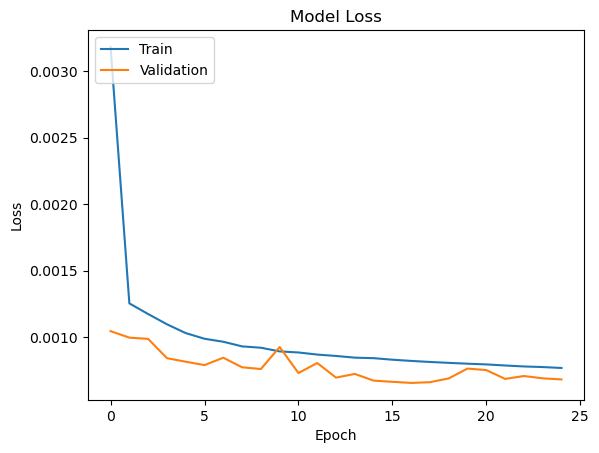

In [83]:
import matplotlib.pyplot as plt

plt.plot(history_e2d2_batch_128_24_in_RidingMill.history['loss'])
plt.plot(history_e2d2_batch_128_24_in_RidingMill.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [84]:
import pickle
with open('history_e2d2_batch_128_24_in_RidingMill.pkl', 'wb') as file:
    pickle.dump(history_e2d2_batch_128_24_in_RidingMill.history, file)

In [85]:
from keras.models import load_model
model_e2d2_batch_128_24_in_RidingMill.save('model_e2d2_batch_128_24_in_RidingMill.h5')

In [86]:
pred_e2d2_batch_128_24_in_RidingMill=model_e2d2_batch_128_24_in_RidingMill.predict(X_test)

380/380 [==============================] - 18s 44ms/step


In [87]:
for index,i in enumerate(train_merged.columns):
    scaler = scalers_RidingMill['scaler_'+i]
    pred_e2d2_batch_128_24_in_RidingMill[:,:,index]=scaler.inverse_transform(pred_e2d2_batch_128_24_in_RidingMill[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])
    y_valid[:,:,index]=scaler.inverse_transform(y_valid[:,:,index])

In [88]:
def calculate_nse(y_true, y_pred):
    
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

for index, i in enumerate(train_merged.columns):
    print(i)
    for j in range(1, 49):
        print("time ", j, ":")
        mae = mean_absolute_error(y_test[:, j - 1, index], pred_e2d2_batch_128_24_in_RidingMill[:, j - 1, index])
        mse = mean_squared_error(y_test[:, j - 1, index], pred_e2d2_batch_128_24_in_RidingMill[:, j - 1, index])
        nse = calculate_nse(y_test[:, j - 1, index], pred_e2d2_batch_128_24_in_RidingMill[:, j - 1, index])
        print("MAE: ", mae)
        print("MSE: ", mse)
        print("NSE: ", nse)
    print()

value_x
time  1 :
MAE:  0.045294410650077326
MSE:  0.027089145451275307
NSE:  0.13377137105800896
time  2 :
MAE:  0.04346712741839248
MSE:  0.02867869646698668
NSE:  0.08294235544916906
time  3 :
MAE:  0.042686614292892895
MSE:  0.029152726396254203
NSE:  0.0677843174650824
time  4 :
MAE:  0.04567113470495526
MSE:  0.029231244636999578
NSE:  0.06527354250726258
time  5 :
MAE:  0.04809685920101263
MSE:  0.029256569572029153
NSE:  0.06446372797146727
time  6 :
MAE:  0.04974797336115934
MSE:  0.029335948175101916
NSE:  0.061925441238475765
time  7 :
MAE:  0.05094249886197324
MSE:  0.029550912984160023
NSE:  0.05505151927751495
time  8 :
MAE:  0.05183116248307155
MSE:  0.029875730754901405
NSE:  0.04466483311528846
time  9 :
MAE:  0.05247073394458938
MSE:  0.030252584001322514
NSE:  0.03261421042042145
time  10 :
MAE:  0.05295632658019673
MSE:  0.03064688197634541
NSE:  0.020005758267029217
time  11 :
MAE:  0.0532776398184309
MSE:  0.030872199439419705
NSE:  0.012800789861267092
time  12 :

the best batch size and window size is 128 and 24, set the epoch to 100 and see if there is further improvement

In [89]:
n_past = 24
n_future = 48 
n_features = 2
X_train, y_train = split(train_RidingMill.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split(test_RidingMill.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
X_valid, y_valid = split(valid_RidingMill.values,n_past, n_future)
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1],n_features))
y_valid = y_valid.reshape((y_valid.shape[0], y_valid.shape[1], n_features))

In [92]:
e_in = tf.keras.layers.Input(shape=(n_past, n_features))
e_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
e_outs1 = e_l1(e_in)
e_states1 = e_outs1[1:]
e_l2 = tf.keras.layers.LSTM(100, return_state=True)
e_outs2 = e_l2(e_outs1[0])
e_states2 = e_outs2[1:]

d_in = tf.keras.layers.RepeatVector(n_future)(e_outs2[0])

d_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(d_in,initial_state = e_states1)
d_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(d_l1,initial_state = e_states2)
d_outs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(d_l2)

model_e2d2_batch_32_24_in_RidingMill_100epoch= tf.keras.models.Model(e_in,d_outs2)

In [93]:
reduce_learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e2d2_batch_32_24_in_RidingMill_100epoch.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2_batch_32_24_in_RidingMill_100epoch=model_e2d2_batch_32_24_in_RidingMill_100epoch.fit(X_train,y_train,epochs=100,validation_data=(X_valid,y_valid),batch_size=32,verbose=1,callbacks=[reduce_learning_rate])

Epoch 1/100
3053/3053 [==============================] - 467s 149ms/step - loss: 0.0018 - val_loss: 9.7640e-04 - lr: 0.0010
Epoch 2/100
3053/3053 [==============================] - 556s 182ms/step - loss: 0.0012 - val_loss: 9.7691e-04 - lr: 9.0000e-04
Epoch 3/100
3053/3053 [==============================] - 521s 171ms/step - loss: 0.0010 - val_loss: 8.0066e-04 - lr: 8.1000e-04
Epoch 4/100
3053/3053 [==============================] - 485s 159ms/step - loss: 9.6886e-04 - val_loss: 8.0885e-04 - lr: 7.2900e-04
Epoch 5/100
3053/3053 [==============================] - 437s 143ms/step - loss: 9.2157e-04 - val_loss: 7.8189e-04 - lr: 6.5610e-04
Epoch 6/100
3053/3053 [==============================] - 400s 131ms/step - loss: 8.9532e-04 - val_loss: 7.1568e-04 - lr: 5.9049e-04
Epoch 7/100
3053/3053 [==============================] - 391s 128ms/step - loss: 8.7385e-04 - val_loss: 7.5782e-04 - lr: 5.3144e-04
Epoch 8/100
3053/3053 [==============================] - 391s 128ms/step - loss: 8.5857e-04 

Epoch 63/100
3053/3053 [==============================] - 370s 121ms/step - loss: 6.1363e-04 - val_loss: 7.0237e-04 - lr: 1.4556e-06
Epoch 64/100
3053/3053 [==============================] - 390s 128ms/step - loss: 6.1347e-04 - val_loss: 6.9854e-04 - lr: 1.3100e-06
Epoch 65/100
3053/3053 [==============================] - 377s 124ms/step - loss: 6.1325e-04 - val_loss: 6.9985e-04 - lr: 1.1790e-06
Epoch 66/100
3053/3053 [==============================] - 380s 124ms/step - loss: 6.1307e-04 - val_loss: 6.9866e-04 - lr: 1.0611e-06
Epoch 67/100
3053/3053 [==============================] - 377s 123ms/step - loss: 6.1289e-04 - val_loss: 7.0164e-04 - lr: 9.5500e-07
Epoch 68/100
3053/3053 [==============================] - 378s 124ms/step - loss: 6.1280e-04 - val_loss: 7.0075e-04 - lr: 8.5950e-07
Epoch 69/100
3053/3053 [==============================] - 369s 121ms/step - loss: 6.1271e-04 - val_loss: 7.0153e-04 - lr: 7.7355e-07
Epoch 70/100
3053/3053 [==============================] - 375s 123ms/

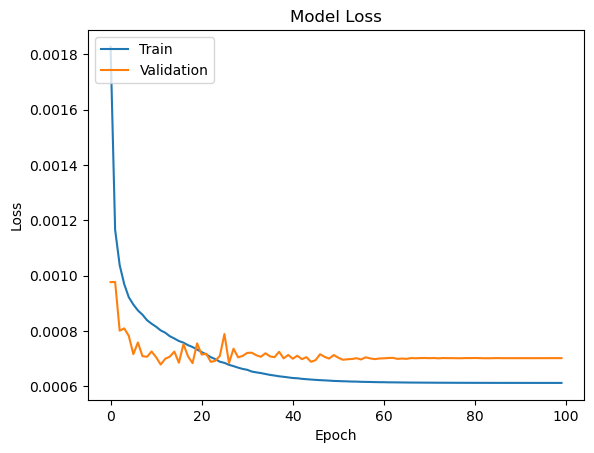

In [94]:
plt.plot(history_e2d2_batch_32_24_in_RidingMill_100epoch.history['loss'])
plt.plot(history_e2d2_batch_32_24_in_RidingMill_100epoch.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [95]:
pred_e2d2_batch_32_24_in_RidingMill_100epoch=model_e2d2_batch_32_24_in_RidingMill_100epoch.predict(X_test)

380/380 [==============================] - 23s 53ms/step


In [97]:
for index,i in enumerate(train_merged.columns):
    scaler = scalers_RidingMill['scaler_'+i]
    pred_e2d2_batch_32_24_in_RidingMill_100epoch[:,:,index]=scaler.inverse_transform(pred_e2d2_batch_32_24_in_RidingMill_100epoch[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])
    y_valid[:,:,index]=scaler.inverse_transform(y_valid[:,:,index])

In [99]:
def calculate_nse(y_true, y_pred):
    
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

for index, i in enumerate(train_merged.columns):
    print(i)
    for j in range(1, 49):
        print("time ", j, ":")
        mae = mean_absolute_error(y_test[:, j - 1, index], pred_e2d2_batch_32_24_in_RidingMill_100epoch[:, j - 1, index])
        mse = mean_squared_error(y_test[:, j - 1, index], pred_e2d2_batch_32_24_in_RidingMill_100epoch[:, j - 1, index])
        nse = calculate_nse(y_test[:, j - 1, index], pred_e2d2_batch_32_24_in_RidingMill_100epoch[:, j - 1, index])
        print("MAE: ", mae)
        print("MSE: ", mse)
        print("NSE: ", nse)
    print()

value_x
time  1 :
MAE:  0.036562220756531386
MSE:  0.026693976541229174
NSE:  0.14640767306928737
time  2 :
MAE:  0.036625943550032625
MSE:  0.029610924824041523
NSE:  0.05313252283392689
time  3 :
MAE:  0.03897314458195147
MSE:  0.029995606890615884
NSE:  0.04083155823884066
time  4 :
MAE:  0.03849068702017757
MSE:  0.029777004422735464
NSE:  0.04782180148501425
time  5 :
MAE:  0.03702457013340921
MSE:  0.029589411136173936
NSE:  0.05382046525642037
time  6 :
MAE:  0.036857763296998025
MSE:  0.029580014841654154
NSE:  0.054120930228032216
time  7 :
MAE:  0.03738809007841337
MSE:  0.029774296562789536
NSE:  0.04790839062502783
time  8 :
MAE:  0.03802523635344371
MSE:  0.030008335598944856
NSE:  0.04042453279081237
time  9 :
MAE:  0.03846690318249114
MSE:  0.03023550174107971
NSE:  0.033160449241279366
time  10 :
MAE:  0.03871413632269583
MSE:  0.030549280358063997
NSE:  0.023126761701356746
time  11 :
MAE:  0.03875785975110511
MSE:  0.030768185521875723
NSE:  0.016126839158284167
time 

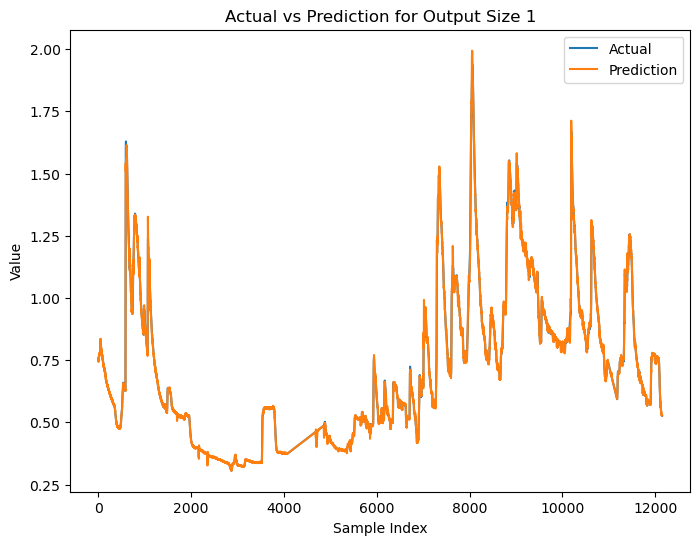

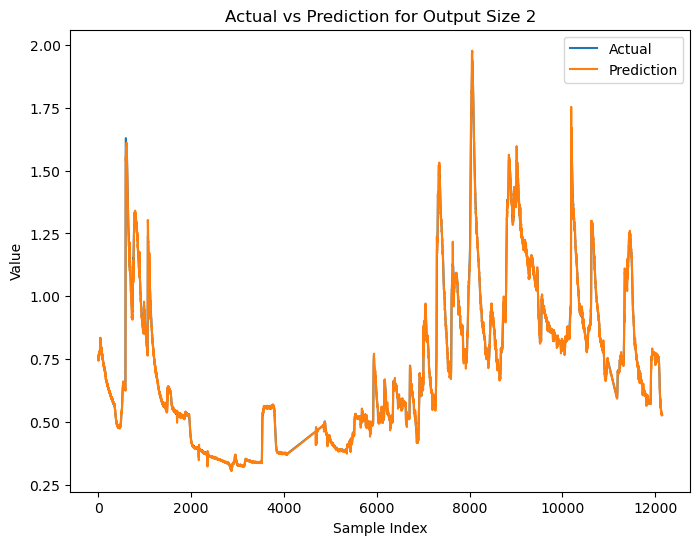

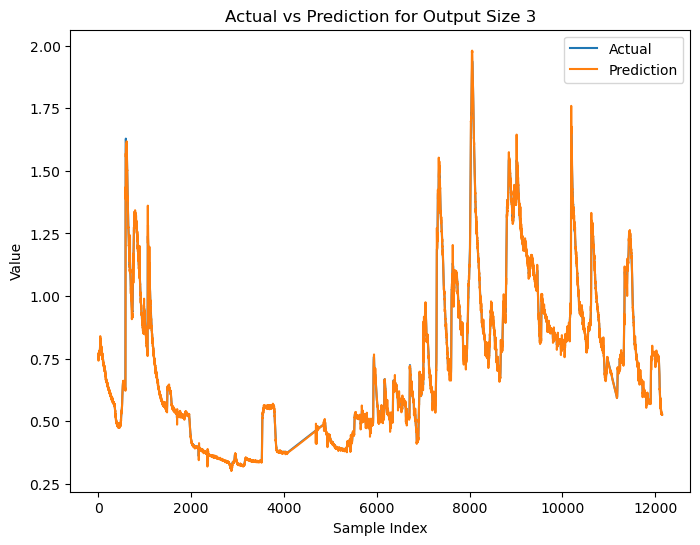

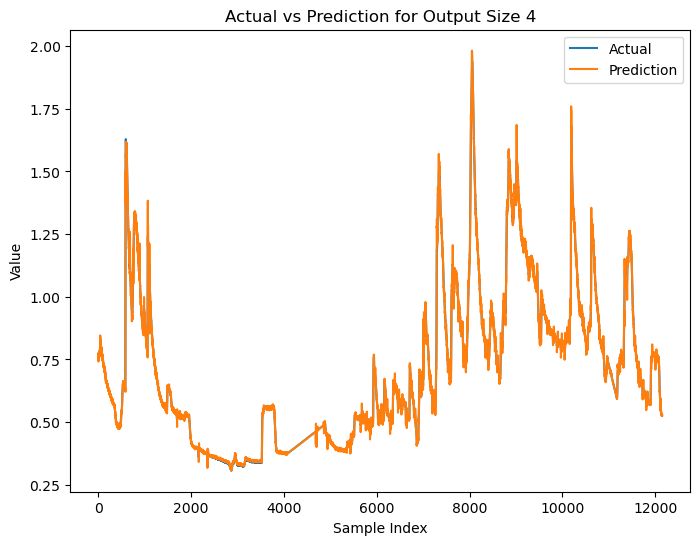

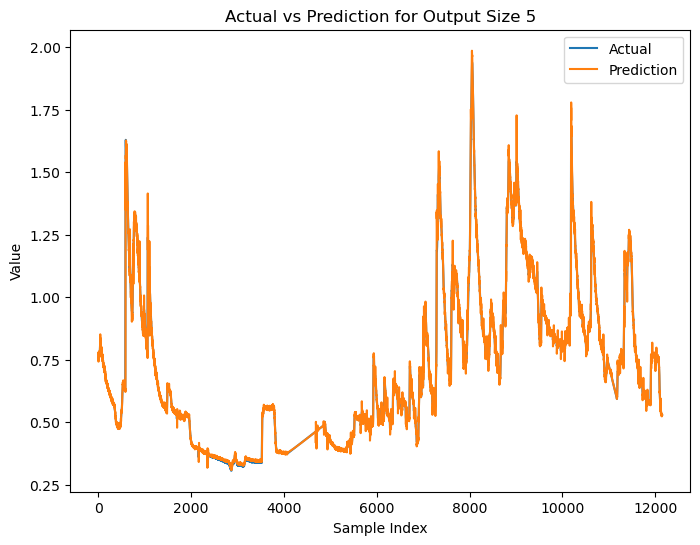

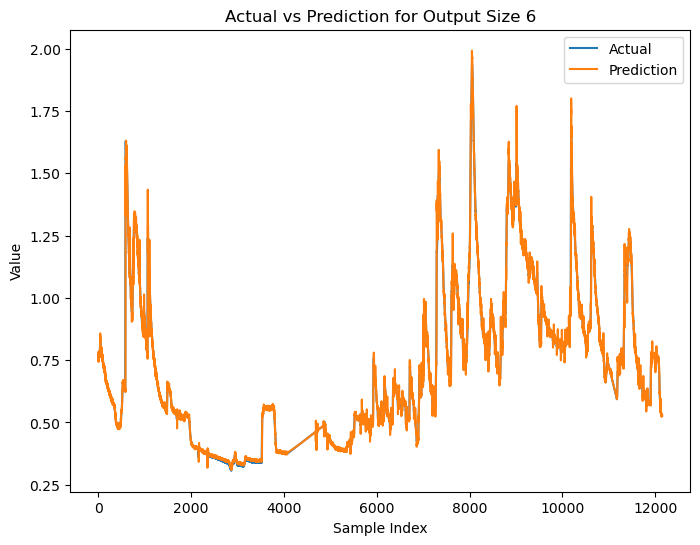

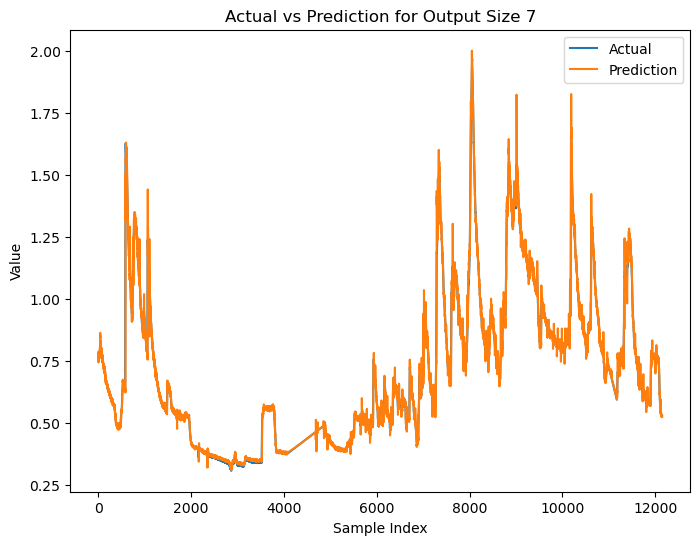

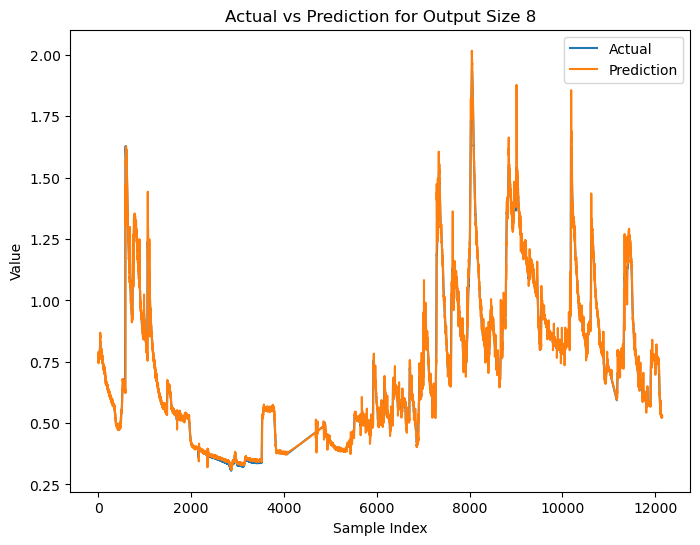

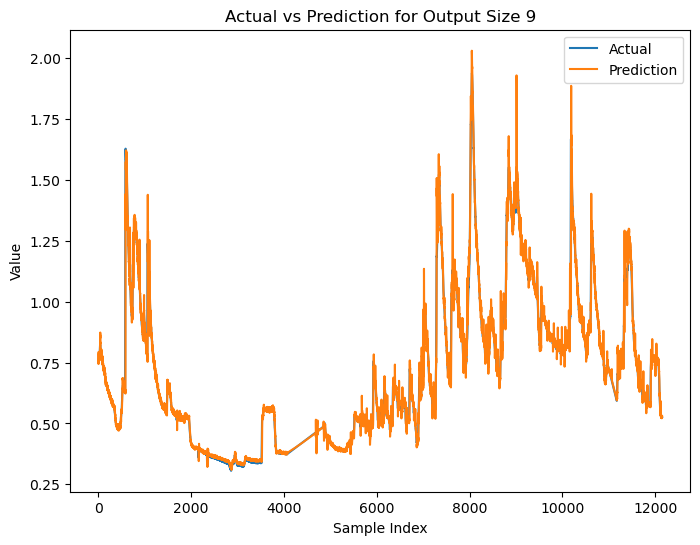

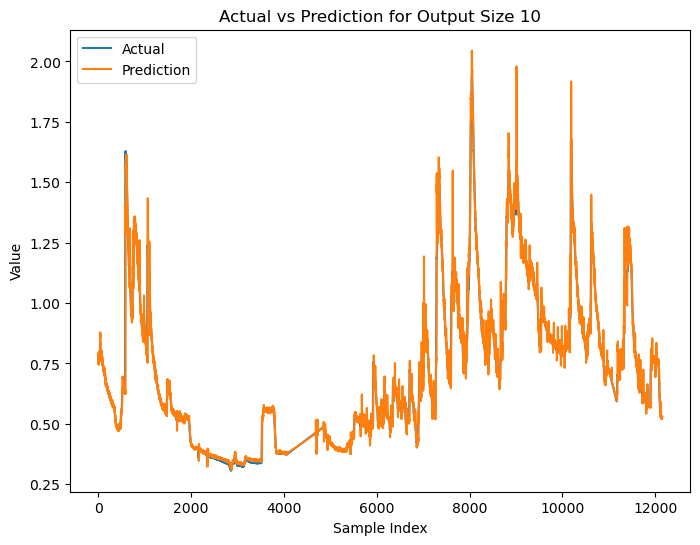

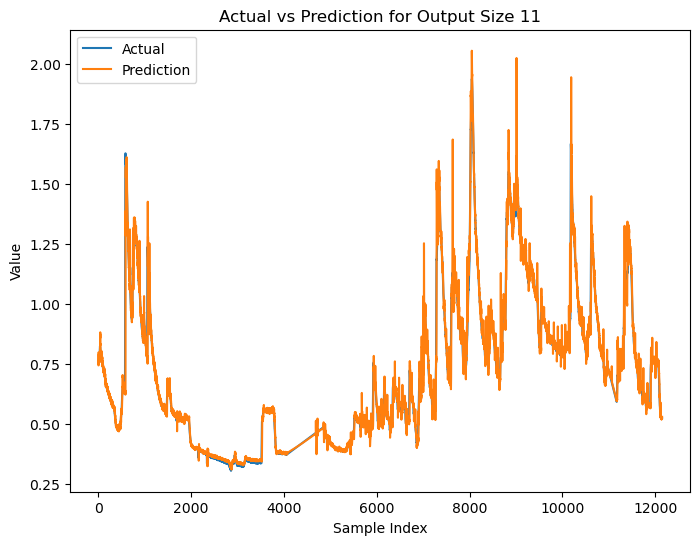

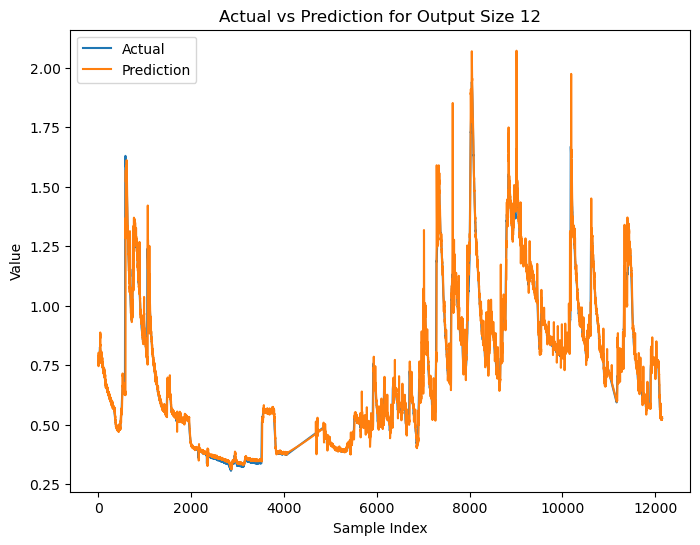

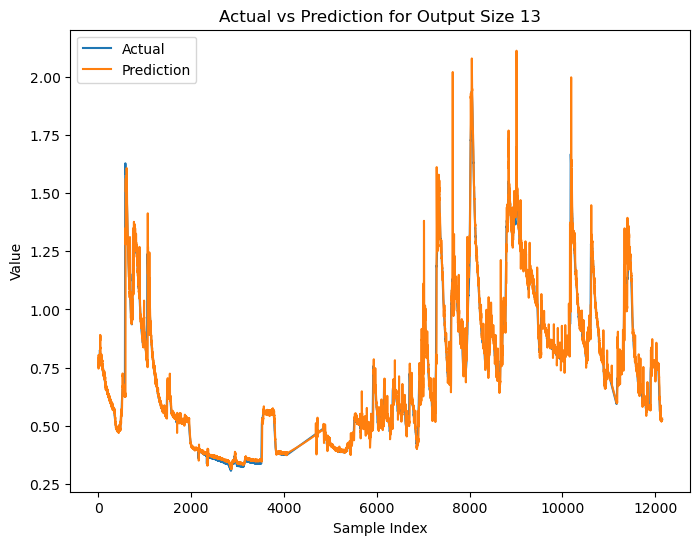

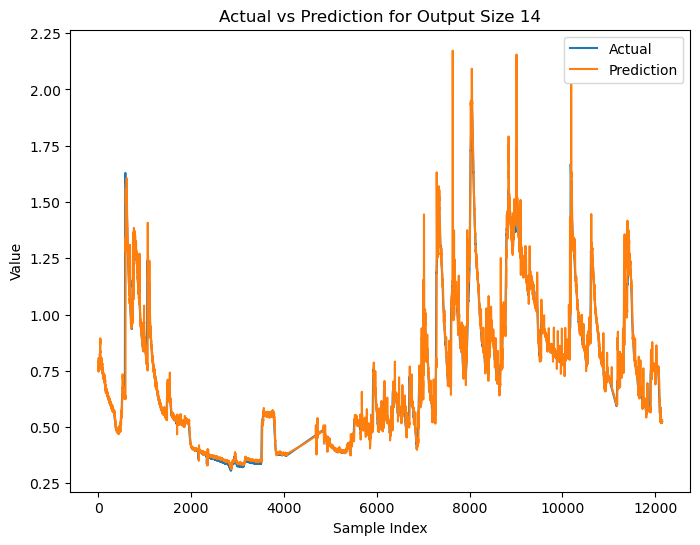

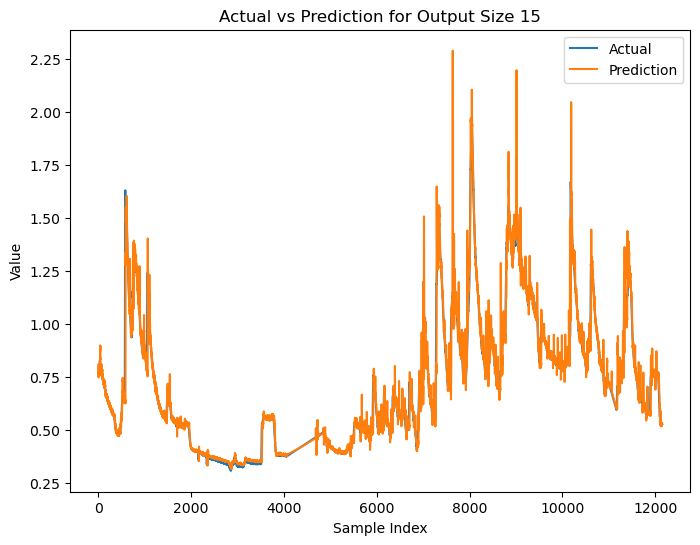

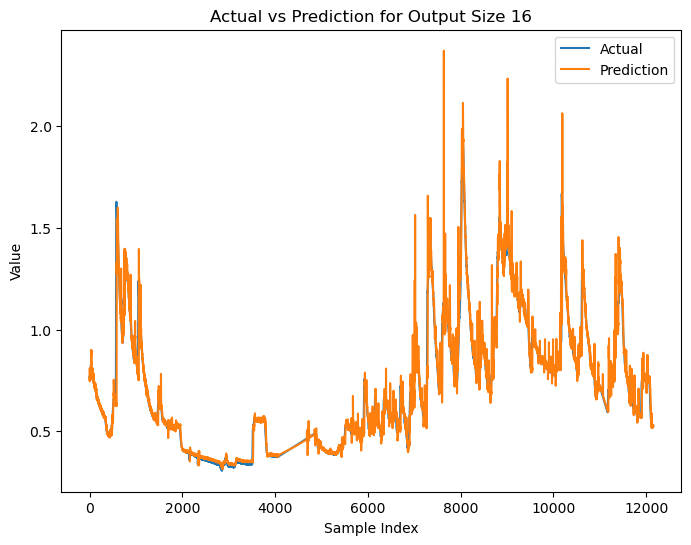

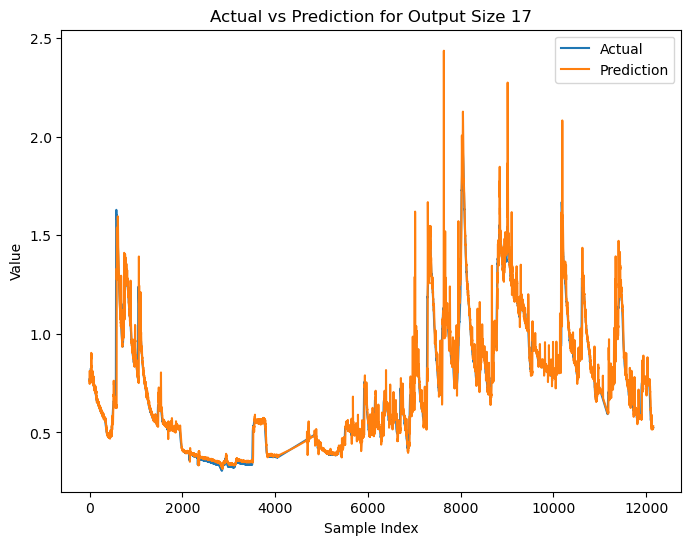

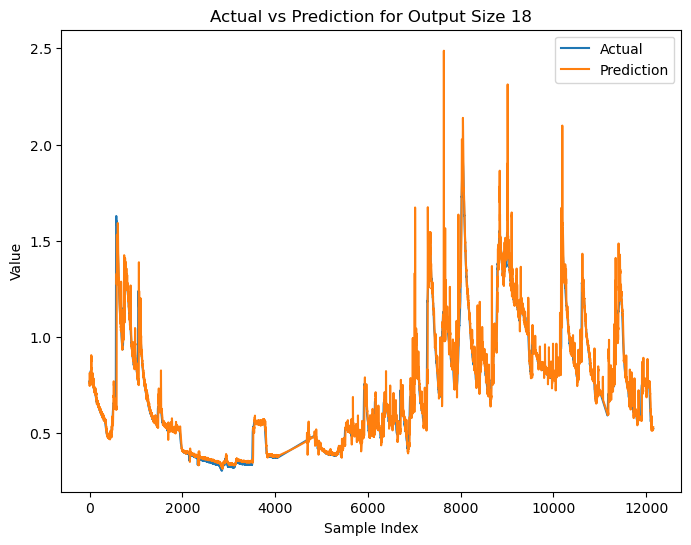

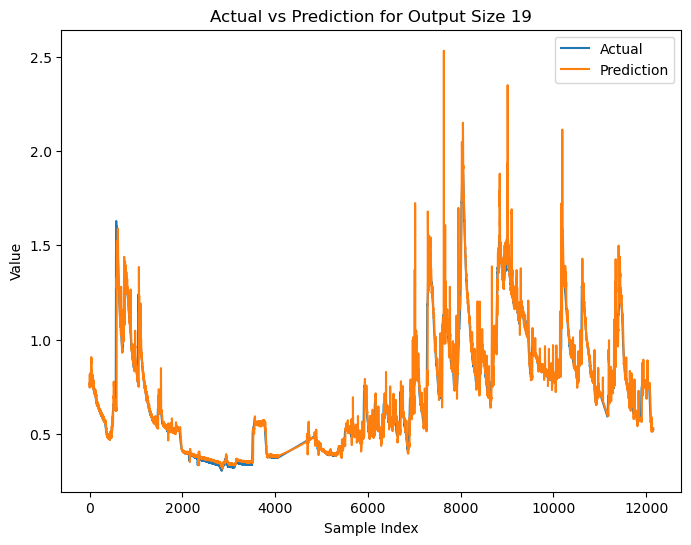

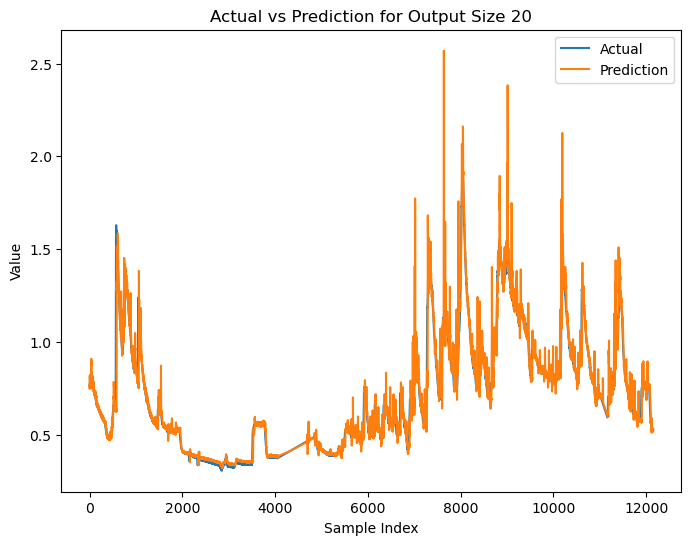

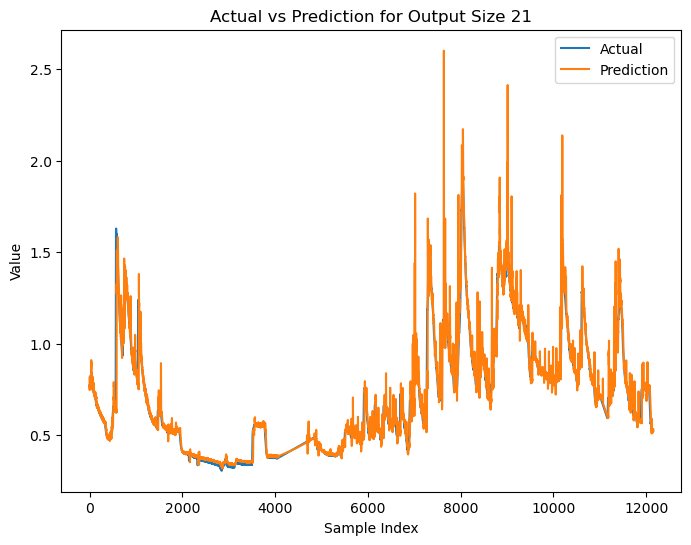

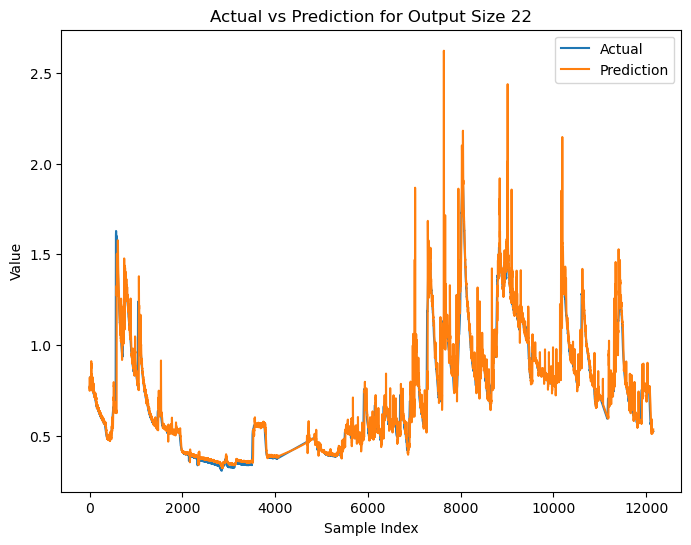

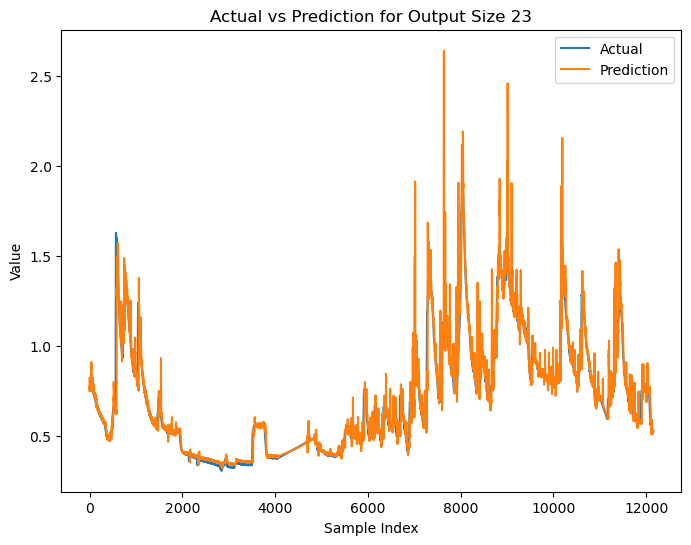

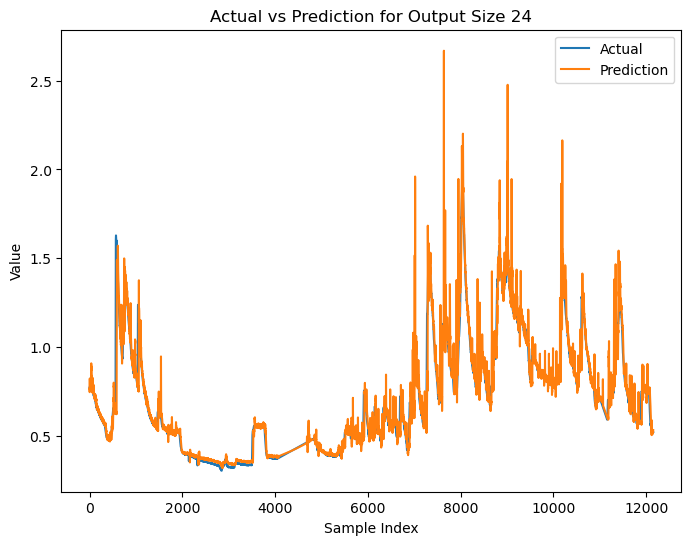

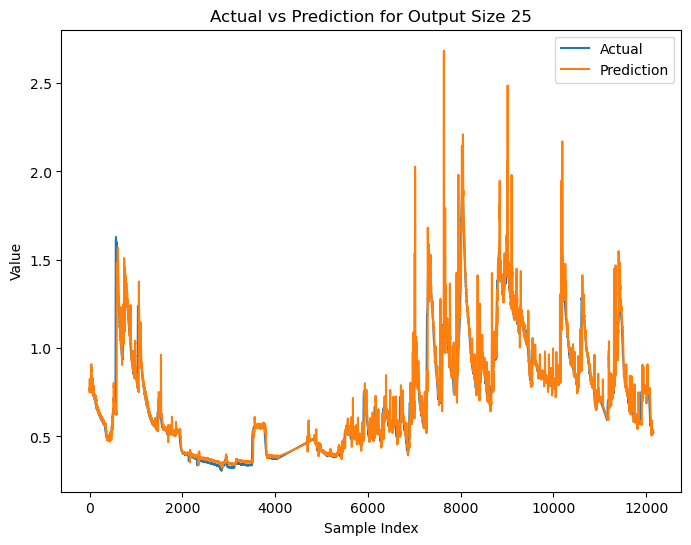

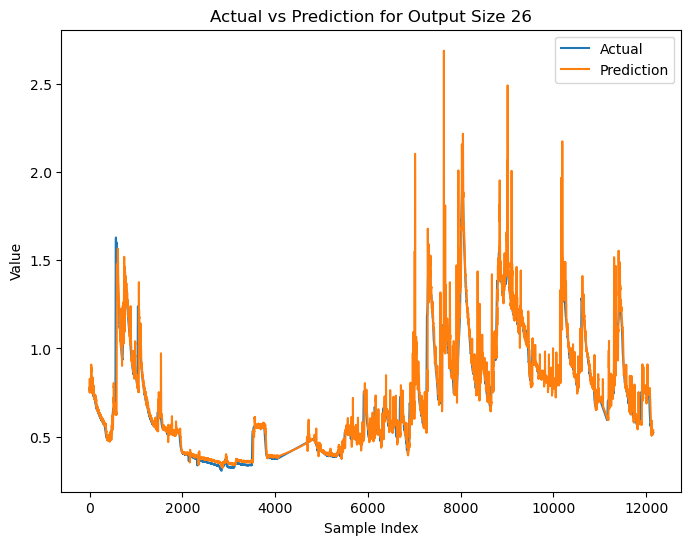

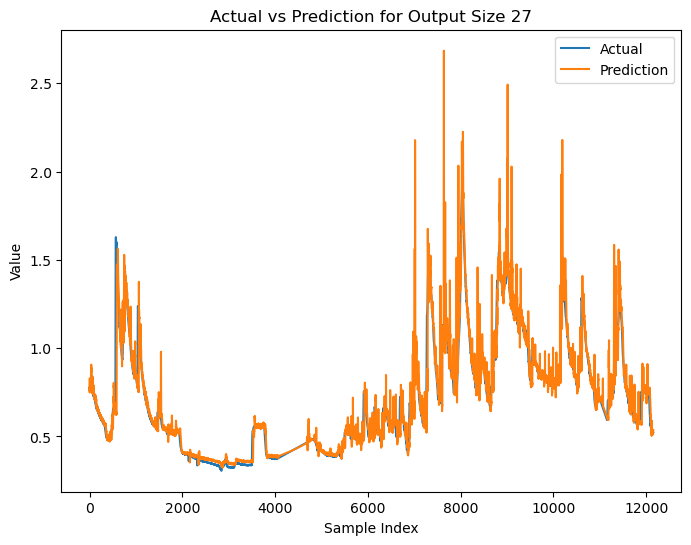

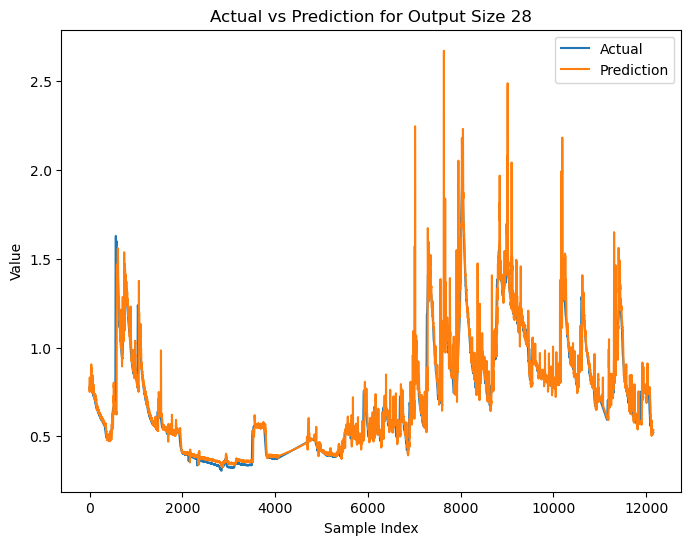

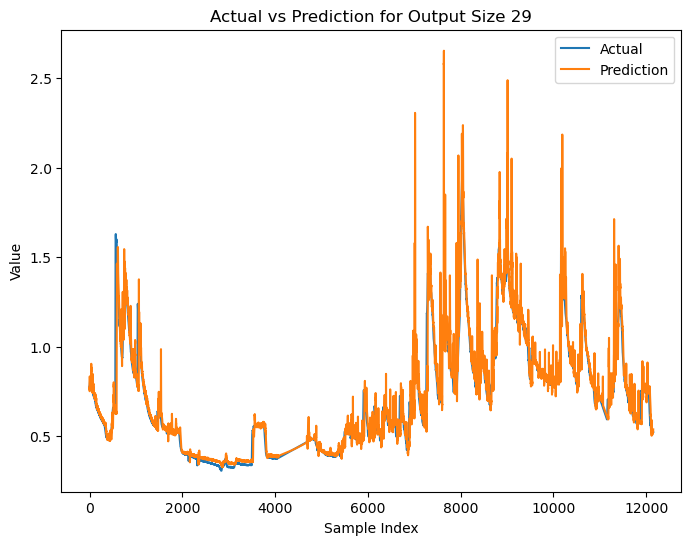

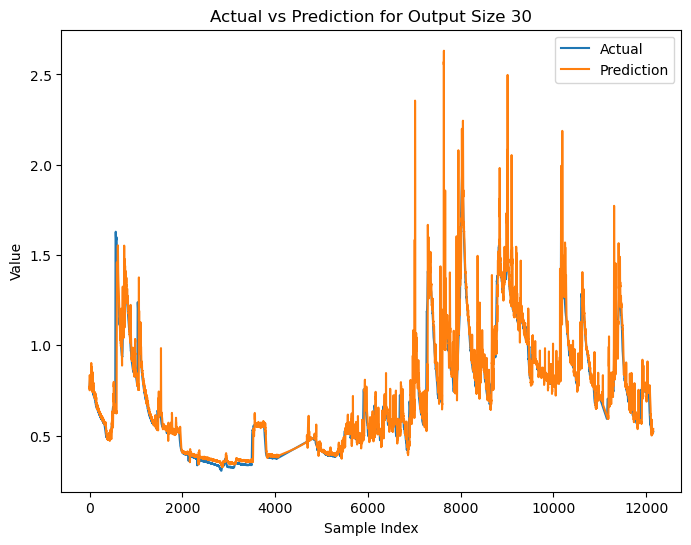

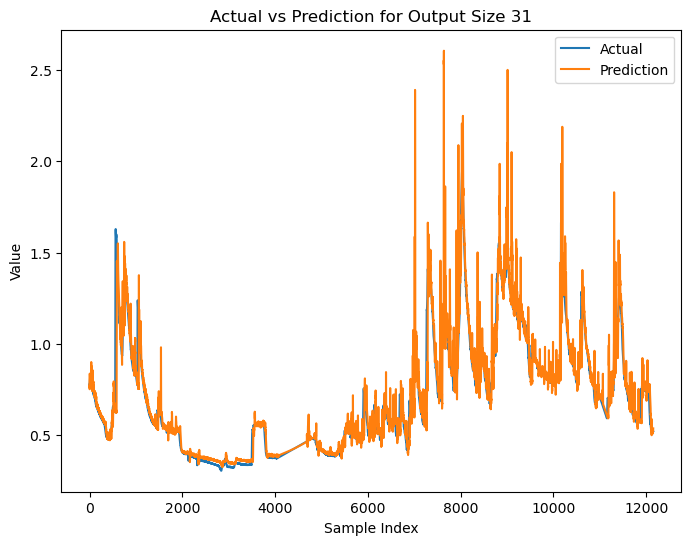

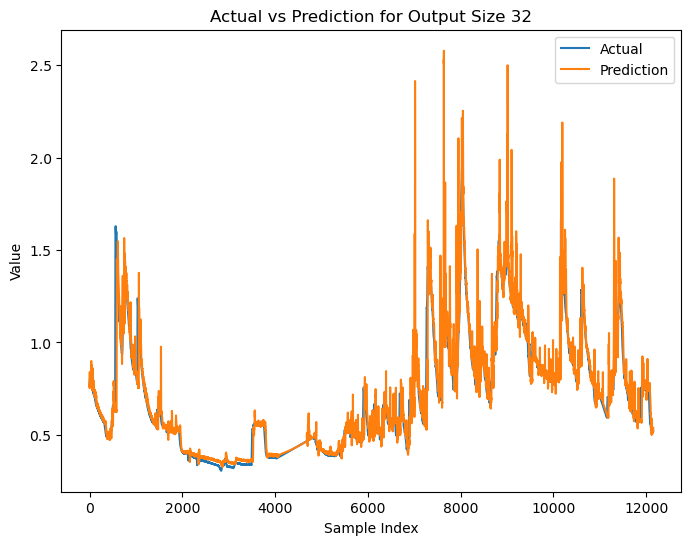

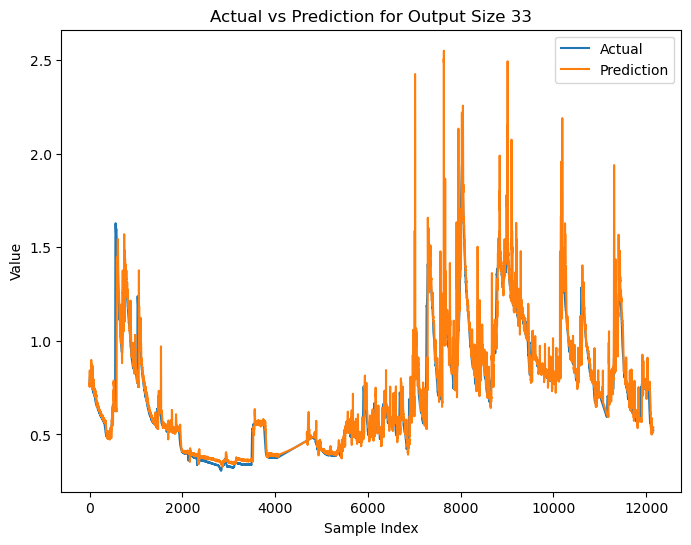

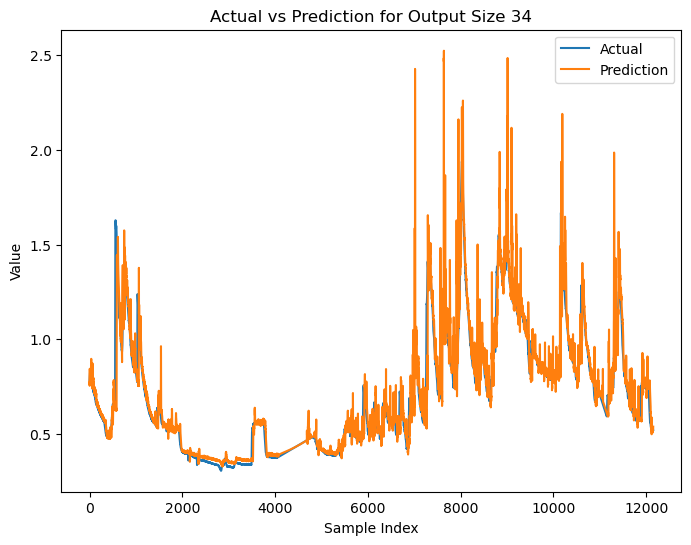

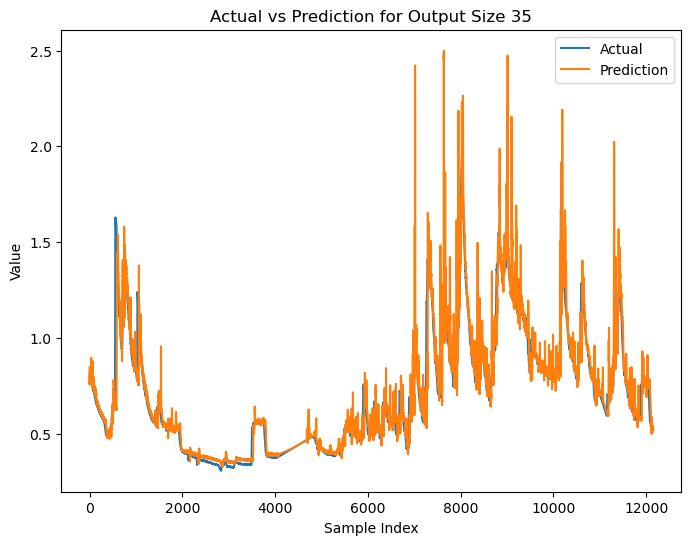

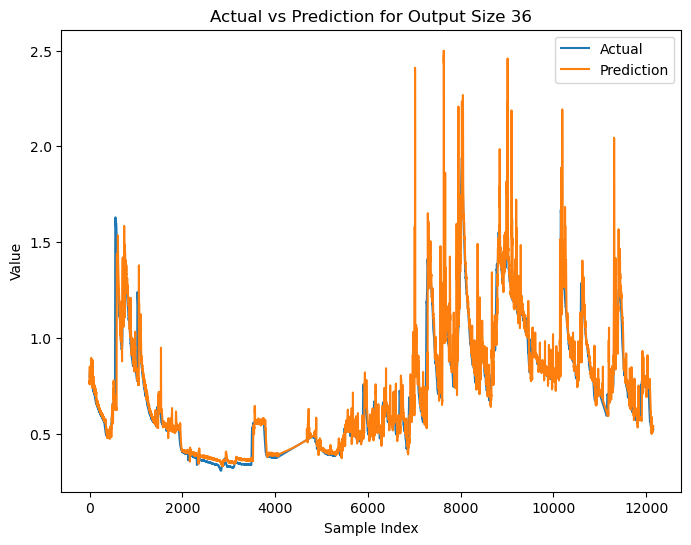

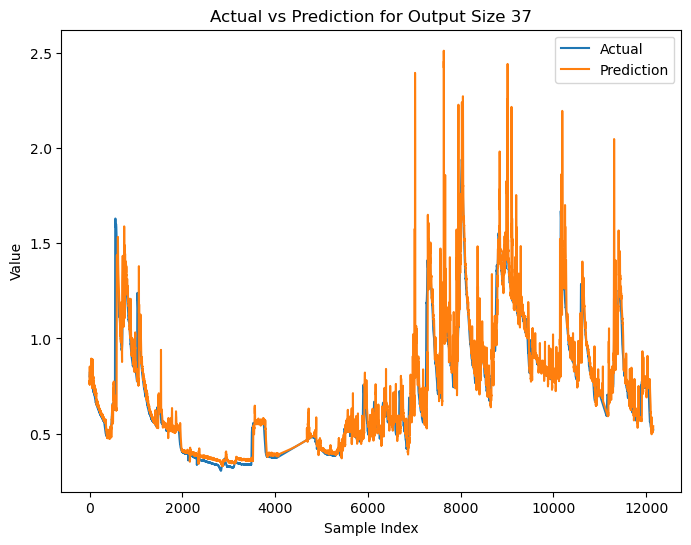

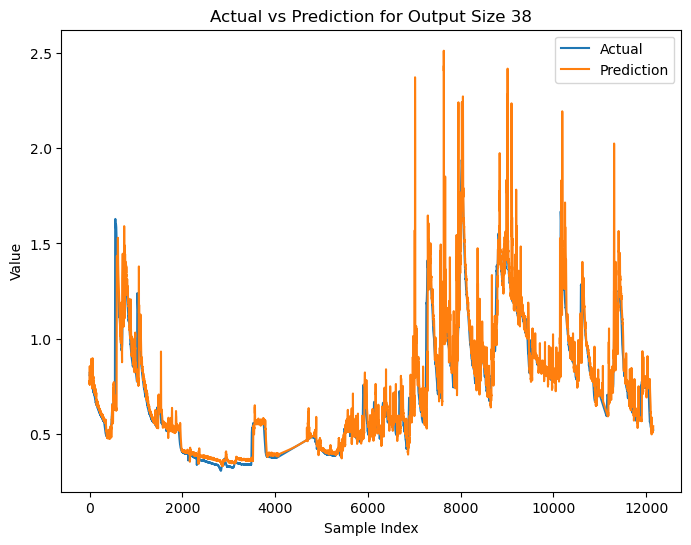

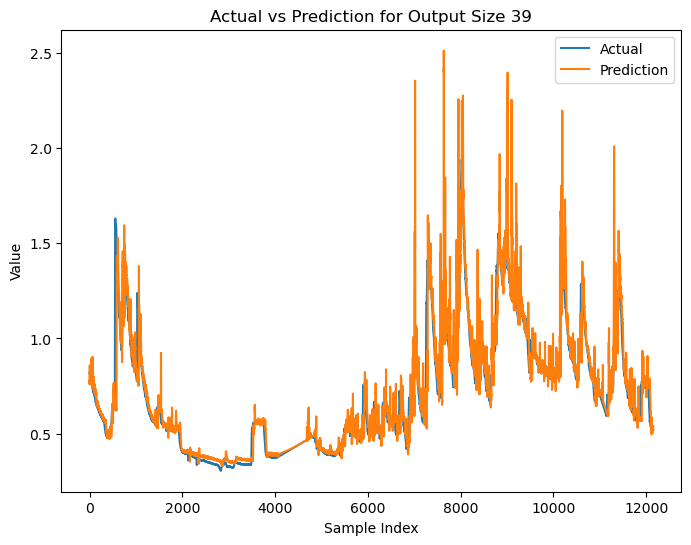

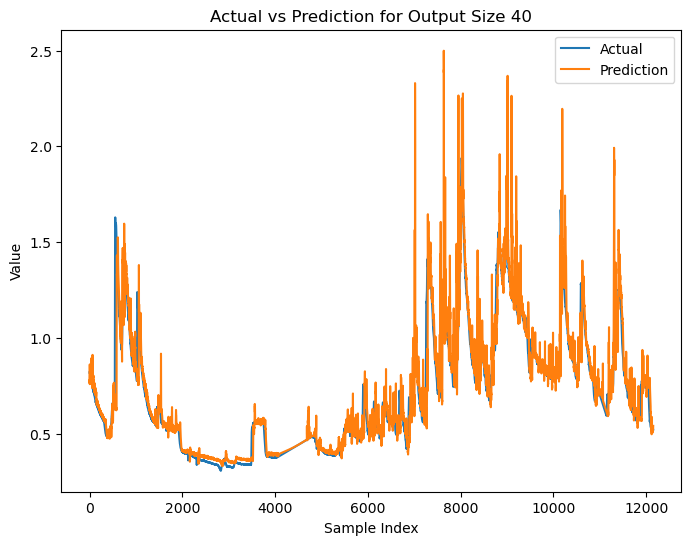

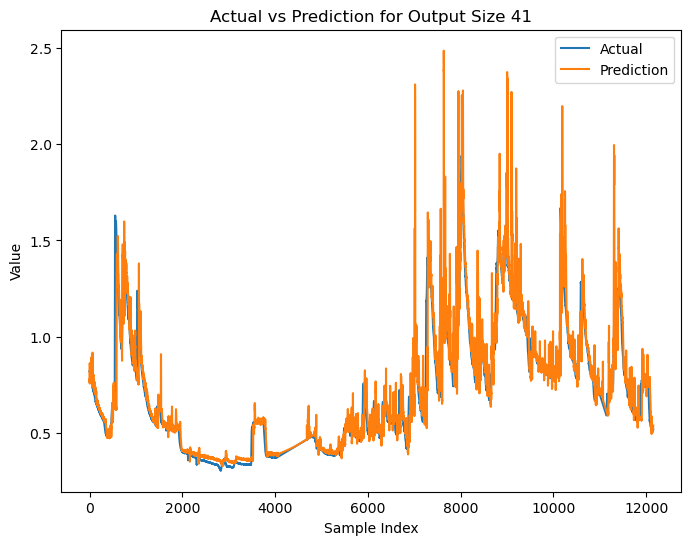

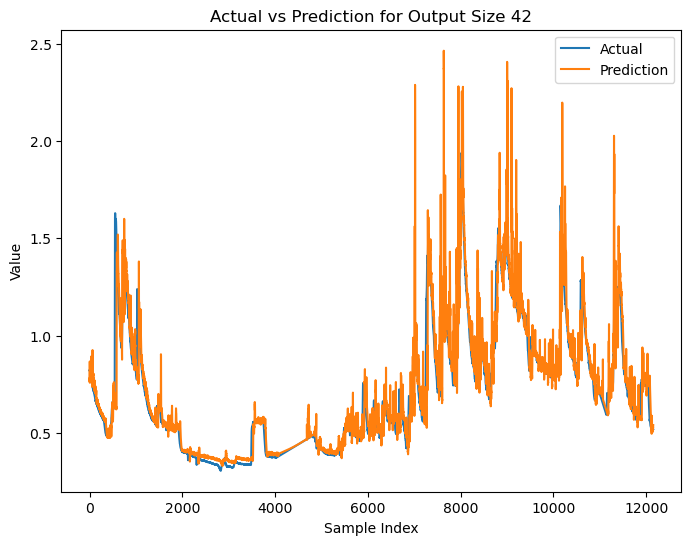

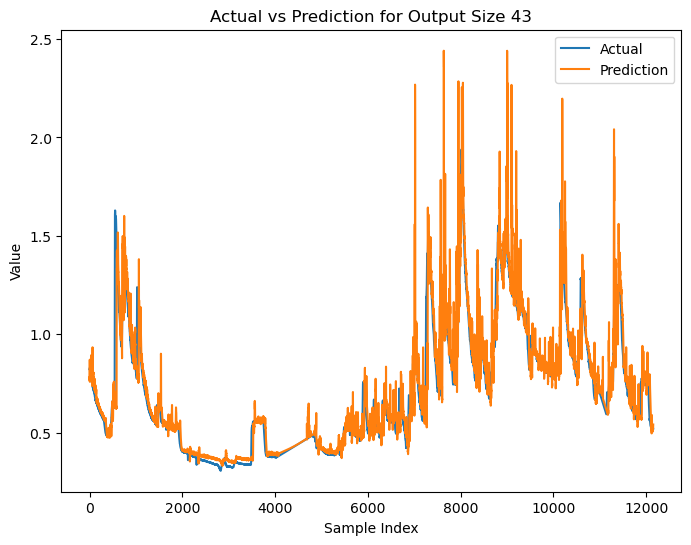

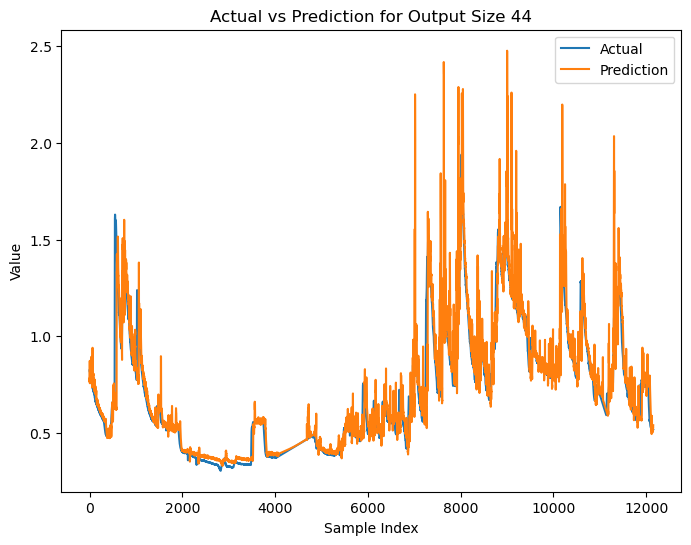

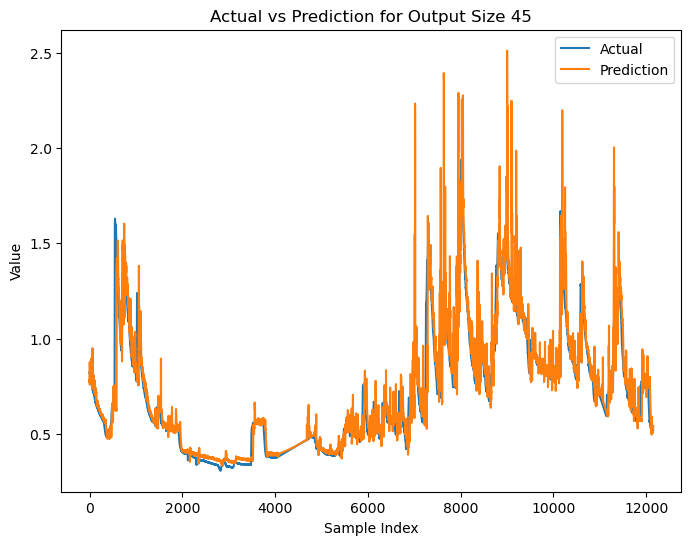

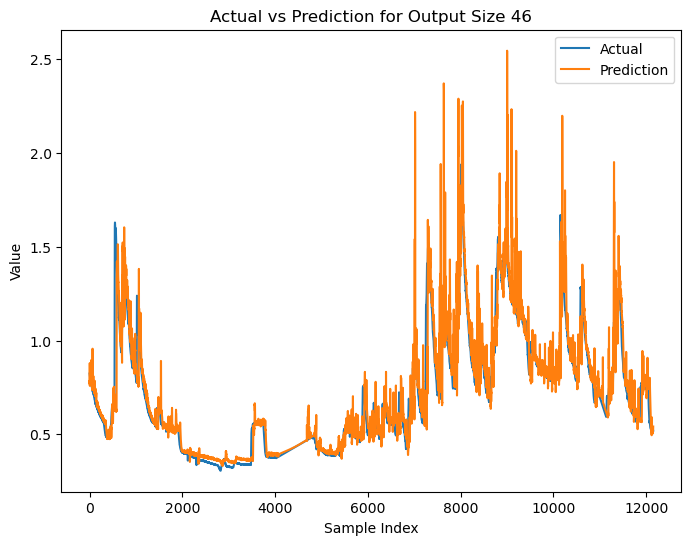

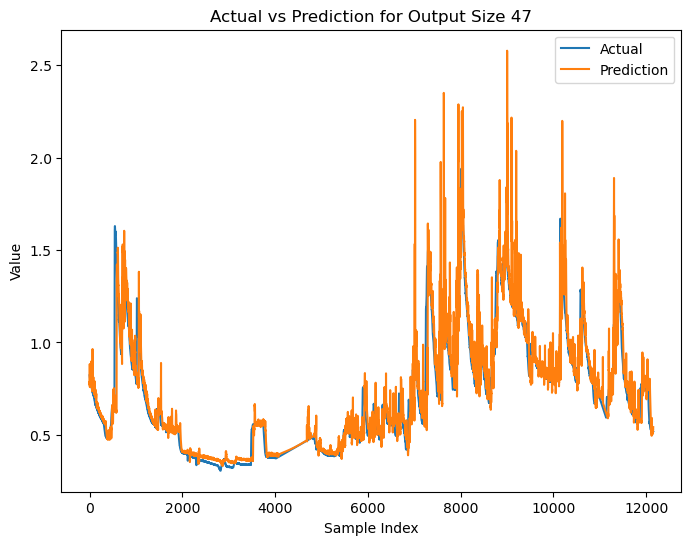

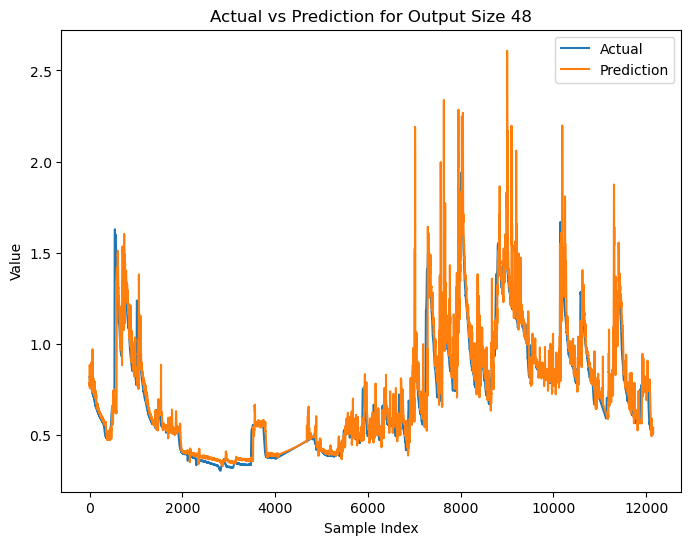

In [100]:
import matplotlib.pyplot as plt
for j in range(1, 49):
    # Plot actual vs prediction for output size j
    plt.figure(figsize=(8, 6))
    plt.plot(y_test[:, j - 1, index], label='Actual')
    plt.plot(pred_e2d2_batch_32_24_in_RidingMill_100epoch[:, j - 1, index], label='Prediction')
    plt.title(f"Actual vs Prediction for Output Size {j}")
    plt.xlabel("Sample Index")
    plt.ylabel("Value")
    plt.legend()
    plt.show()